# Implémenter un modèle de scoring

In [1]:
# =========================
# Core Python
# =========================
import os
import gc
import time
import re
import random
import warnings
from contextlib import contextmanager


# =========================
# Data manipulation
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# =========================
# Jupyter / Display
# =========================
from IPython.display import display

# =========================
# Experiment tracking & optimization
# =========================
import mlflow
from mlflow.tracking import MlflowClient
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# =========================
# Machine Learning - Models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# =========================
# Machine Learning - Preprocessing & Pipeline
# =========================
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler
)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# =========================
# Machine Learning - Model selection
# =========================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve
)

# =========================
# Machine Learning - Metrics
# =========================
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

# =========================
# Explainability
# =========================
import shap
from pathlib import Path


/Users/steph/Code/Python/Jupyter/OCR_projet06/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/steph/Code/Python/Jupyter/OCR_projet06/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Notebook run toggles
RUN_LEGACY_PREPROCESSING = True
RUN_FULL_BENCHMARK = True
RUN_MLFLOW_LOGGING = True


In [3]:
# Affichage des erreurs
warnings.filterwarnings("ignore")

## Loading and reading datasets

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [5]:
def build_df_initial(app_train, app_test):
    app_train = app_train.copy()
    app_test = app_test.copy()

    app_train['is_train'] = 1
    app_train['is_test'] = 0
    app_test['is_train'] = 0
    app_test['is_test'] = 1

    df_initial = pd.concat([app_train, app_test], axis=0, ignore_index=True, sort=False)
    return df_initial


def build_df_final(app_train, app_test, prev_app, bureau, pos_cash_bal, inst_pay, cred_card_bal):
    app_train = app_train.copy()
    app_test = app_test.copy()

    app_train['is_train'] = 1
    app_train['is_test'] = 0
    app_test['is_train'] = 0
    app_test['is_test'] = 1

    train_X = app_train.drop(['TARGET'], axis=1)
    test_X = app_test

    with timer("Process previous application data " ):
        prev_app = prev_app.copy()
        prev_apps_count = prev_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        prev_app['SK_ID_PREV'] = prev_app['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])
        prev_apps_avg = prev_app.select_dtypes(include=['number']).groupby('SK_ID_CURR').mean()
        prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]

    with timer("Process bureau data " ):
        bureau_avg = bureau.select_dtypes(include=['number']).groupby('SK_ID_CURR').mean()
        bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
        bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]

    with timer("Process installments data " ):
        inst_pay = inst_pay.copy()
        count_inst = inst_pay[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        inst_pay['SK_ID_PREV'] = inst_pay['SK_ID_CURR'].map(count_inst['SK_ID_PREV'])
        avg_inst = inst_pay.select_dtypes(include=['number']).groupby('SK_ID_CURR').mean()
        avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]

    with timer("Process POS_CASH_balance data " ):
        pos_cash_bal = pos_cash_bal.copy()
        pcb_count = pos_cash_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        pos_cash_bal['SK_ID_PREV'] = pos_cash_bal['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
        pcb_avg = pos_cash_bal.select_dtypes(include=['number']).groupby('SK_ID_CURR').mean()

    with timer("Process credit_card_balance data " ):
        cred_card_bal = cred_card_bal.copy()
        nb_prevs = cred_card_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
        cred_card_bal['SK_ID_PREV'] = cred_card_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
        avg_cc_bal = cred_card_bal.select_dtypes(include=['number']).groupby('SK_ID_CURR').mean()
        avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

    with timer("Merging data for preprocessing " ):
        data = pd.concat([train_X, test_X], axis=0, ignore_index=True, sort=False)
        data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
        data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

    df_final = data.copy()
    target = pd.concat(
        [app_train['TARGET'].reset_index(drop=True), pd.Series([np.nan] * len(app_test))],
        ignore_index=True,
    )
    df_final.insert(1, 'TARGET', target)

    return df_final


def _resolve_data_dir() -> Path:
    candidates = [Path.cwd() / 'data', Path.cwd().parent / 'data']
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return candidates[0]


def read_datasets():
    data_dir = _resolve_data_dir()
    with timer("Datasets loaded"):
        print("Loading data ... ")
        app_train = pd.read_parquet(data_dir / 'application_train.parquet')
        print("	application_train cols_num: {}, obervations: {}".format(len(app_train.columns),
                                                                         app_train.shape[0]))

        app_test = pd.read_parquet(data_dir / 'application_test.parquet')
        print("	application_test cols_num: {}, obervations: {}".format(len(app_test.columns),
                                                                        app_test.shape[0]))

        initial_path = data_dir / 'data_initial.parquet'
        final_path = data_dir / 'data_final.parquet'

        if initial_path.exists() and final_path.exists():
            df_initial = pd.read_parquet(initial_path)
            df_final = pd.read_parquet(final_path)
        else:
            print("	Missing engineered datasets, generating from raw tables ...")

            df_initial = build_df_initial(app_train, app_test)

            prev_app = pd.read_parquet(data_dir / 'previous_application.parquet')
            bureau = pd.read_parquet(data_dir / 'bureau.parquet')
            pos_cash_bal = pd.read_parquet(data_dir / 'POS_CASH_balance.parquet')
            inst_pay = pd.read_parquet(data_dir / 'installments_payments.parquet')
            cred_card_bal = pd.read_parquet(data_dir / 'credit_card_balance.parquet')

            df_final = build_df_final(
                app_train,
                app_test,
                prev_app,
                bureau,
                pos_cash_bal,
                inst_pay,
                cred_card_bal,
            )

            df_initial.to_parquet(initial_path)
            df_final.to_parquet(final_path)

        print("	df_initial cols_num: {}, obervations: {}".format(len(df_initial.columns),
                                                                  df_initial.shape[0]))
        print("	df_final cols_num: {}, obervations: {}".format(len(df_final.columns),
                                                                df_final.shape[0]))

    return app_train, app_test, df_initial, df_final


In [6]:
app_train, app_test, df_initial, df_final = read_datasets()

Loading data ... 
	application_train cols_num: 122, obervations: 307511
	application_test cols_num: 121, obervations: 48744
	df_initial cols_num: 124, obervations: 356255
	df_final cols_num: 192, obervations: 356255
Datasets loaded - done in 1s


In [7]:
# Fonction permettant d'avoir une description du dataset

def dataset_overview(df):
    ''' function taking a dataframe in input and prints a dataframe summary containing
    number of rows, columns, missing cells and duplicate rows'''
    
    print('******** Dataset Overview *****\n')
    
    print ('Shape of the Dataset : {}'.format(df.shape))
    print ('Number of variables : {}'.format(df.shape[1]))
    print (' - Num. Quantitative variables : {}'.format(len(df.select_dtypes(include=["float64","int64"]).columns)))
    print (' - Num. Catégorielles variables : {}'.format(len(df.select_dtypes(include=["object"]).columns)))
    print ('Number of obervations : {}'.format(df.shape[0]))
    print ('Number of cells : {}'.format(df.size))
    print ('Missing cells : {}'.format(df.isna().sum().sum()))
    print ('Missing cells in % : {:.2%}'.format(df.isna().sum().sum()/(df.size)))
    print ('Duplicate rows : {}'.format(len(df)-len(df.drop_duplicates())))
    print ('Duplicate rows in % : {:.4%}'.format((len(df)-len(df.drop_duplicates())) / (df.shape[0])))
    print("\n************** End ************")

In [8]:
# Fonction qui renvoie la proportion de NaN sur l'ensemble du dataset
def print_proportion_nan(df):
    print('Taille du jeu de données : ', df.shape)
    print(' --> Proportion de NaN : {:.2%}'.format(df.isna().sum().sum()/(df.shape[0]*df.shape[1]))) 
              
    return None

In [9]:
dataset_overview(df_initial)

******** Dataset Overview *****

Shape of the Dataset : (356255, 124)
Number of variables : 124
 - Num. Quantitative variables : 108
 - Num. Catégorielles variables : 16
Number of obervations : 356255
Number of cells : 44175620
Missing cells : 10605628
Missing cells in % : 24.01%
Duplicate rows : 0
Duplicate rows in % : 0.0000%

************** End ************


In [10]:
dataset_overview(df_final)

******** Dataset Overview *****

Shape of the Dataset : (356255, 192)
Number of variables : 192
 - Num. Quantitative variables : 176
 - Num. Catégorielles variables : 16
Number of obervations : 356255
Number of cells : 68400960
Missing cells : 18488785
Missing cells in % : 27.03%
Duplicate rows : 0
Duplicate rows in % : 0.0000%

************** End ************


In [11]:
def cat_num_variable(df):
    
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    all_numeric_columns = df.select_dtypes(exclude=['object']).columns.to_list()
    numeric_columns = [col for col in all_numeric_columns if col not in ignore_features]
    
    print("Number of categorical features: ", len(categorical_columns))
    print("First 05 cat. features :", cat_columns[:5])
    print("\nNumber of categorical features: ",len(numeric_columns))
    print("First 05 num. Features :",num_columns[:5], "\n")
    
    return categorical_columns, numeric_columns

In [12]:
#cat_columns, num_columns = cat_num_variable(df_initial)

## Preprocessing - preparing data for modeling

In [13]:
from pathlib import Path
import sys

project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.append(str(project_root))

from src.features import (
    add_missingness_indicators,
    apply_outlier_clipping,
    compute_outlier_bounds,
    new_features_creation,
    select_missing_indicator_columns,
)

DAYS_EMPLOYED_SENTINEL = 365243
MISSING_INDICATOR_MIN_RATE = 0.05

ENGINEERED_SOURCES = [
    "DAYS_EMPLOYED",
    "DAYS_BIRTH",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "CNT_FAM_MEMBERS",
    "AMT_ANNUITY",
]

OUTLIER_COLUMNS = [
    "CNT_FAM_MEMBERS",
    "AMT_INCOME_TOTAL",
    "AMT_ANNUITY",
    "DAYS_EMPLOYED",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "REGION_POPULATION_RELATIVE",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "AMT_REQ_CREDIT_BUREAU_QRT",
]
OUTLIER_LOWER_Q = 0.01
OUTLIER_UPPER_Q = 0.99


In [14]:
def nan_imputation(df):
    
    with timer("Filtering cols with a given % of missing_rate "):
        # deleting all features with more than 
        missing_rate = df.isna().sum()/df.shape[0] 
        df1 = df[df.columns[missing_rate < 0.60]]
    
        # Droping all row containing Nan for feature with less than 1% of Nan
        less_one_percent = df.columns[missing_rate < 0.010].to_list()
        df2 = df1.dropna(subset=less_one_percent)
   
    with timer("Imputing numeric nan value with median "):
        # Filling missing numeric value with median 
        numeric_cols = df2.select_dtypes(include=['number']).columns
        df3 = df2.copy()
        df3[numeric_cols] = df2[numeric_cols].fillna(df2[numeric_cols].median())
    
    with timer("Imputing categorical nan value with Unknown "):
        # Filling missing catégorical value with Unknown
        categorical_columns = [col for col in df3.columns if df3[col].dtype == 'object']
        for col in categorical_columns:
            df3[col] = df3[col].replace(np.nan, 'Unknown')
    
    df_imputed = df3.copy()
    
    num_features_deleted = df.shape[1] - df_imputed.shape[1]
    num_observations_deleted = df.shape[0] - df_imputed.shape[0]
    
    print("\nTaille du jeu de donnée avant imputation: ", df.shape)
    print("Taille du jeu de donnée après imputation: ", df_imputed.shape)
    print(f"\tSoit {num_features_deleted} variables et {num_observations_deleted} observations supprimées")
    print('Proportion de données supprimés : {:.4%}'.format(num_observations_deleted/(df.shape[0]*df.shape[1])))
    
    return df_imputed


In [15]:
# Outlier helpers moved to src.features (kept for reference)


### Annexe (legacy) — preprocessing manuel (get_dummies + scaling)
Ces cellules sont conservees pour reference, mais desactivees par defaut.


In [16]:
def features_encoding(train_df, test_df):
    
    with timer("Encoding categorical features "):
        # Encode des variable catégorielles
        categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']
        train_hot_encode = pd.get_dummies(train_df, columns= categorical_columns)
        test_hot_encode = pd.get_dummies(test_df, columns= categorical_columns)
        test_hot_encode = test_hot_encode.reindex(columns=train_hot_encode.columns, fill_value=0)
    
    with timer("Scaling numeric features "):
        # Standardisation des variables numériques 
        ignore_features = ['is_train', 'is_test', 'TARGET', 'SK_ID_CURR']
        features_to_scaled = [col for col in train_hot_encode.columns if col not in ignore_features]
     
        scaler = MinMaxScaler()
        scaler.fit(train_hot_encode[features_to_scaled])
        train_scaled = scaler.transform(train_hot_encode[features_to_scaled])
        test_scaled = scaler.transform(test_hot_encode[features_to_scaled])
        train_scaled = pd.DataFrame(train_scaled, columns=features_to_scaled, index=train_hot_encode.index)
        test_scaled = pd.DataFrame(test_scaled, columns=features_to_scaled, index=test_hot_encode.index)
    
    train_ignore = [col for col in ignore_features if col in train_hot_encode.columns]
    test_ignore = [col for col in ignore_features if col in test_hot_encode.columns]
    train_encoded = pd.concat([train_hot_encode[train_ignore], train_scaled], axis=1)
    test_encoded = pd.concat([test_hot_encode[test_ignore], test_scaled], axis=1)
    
    return train_encoded, test_encoded


In [17]:
def preprocessing(df) :

    with timer("Preparing data for modeling "):
        df = new_features_creation(
            df,
            days_employed_sentinel=DAYS_EMPLOYED_SENTINEL,
            engineered_sources=ENGINEERED_SOURCES,
        )
        train_df = df[df['is_train'] == 1].copy()
        test_df = df[df['is_test'] == 1].copy()

        # Filter columns based on train only (avoid leakage)
        missing_rate = train_df.isna().sum() / train_df.shape[0]
        cols_keep = missing_rate[missing_rate < 0.60].index.tolist()
        for col in ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']:
            if col in train_df.columns and col not in cols_keep:
                cols_keep.append(col)
        train_df = train_df[cols_keep]
        test_df = test_df[cols_keep]

        # Drop rows with critical missing values only in train
        less_one_percent = missing_rate[missing_rate < 0.010].index.to_list()
        if less_one_percent:
            train_df = train_df.dropna(subset=less_one_percent)

        missing_indicator_columns = select_missing_indicator_columns(
            train_df,
            exclude_cols={'is_train', 'is_test', 'SK_ID_CURR', 'TARGET'},
            min_missing_rate=MISSING_INDICATOR_MIN_RATE,
        )
        train_df = add_missingness_indicators(train_df, missing_indicator_columns)
        test_df = add_missingness_indicators(test_df, missing_indicator_columns)

        # Impute using train statistics only
        numeric_cols = train_df.select_dtypes(include=['number']).columns
        medians = train_df[numeric_cols].median()
        train_df[numeric_cols] = train_df[numeric_cols].fillna(medians)
        test_df[numeric_cols] = test_df[numeric_cols].fillna(medians)

        categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']
        for col in categorical_columns:
            train_df[col] = train_df[col].replace(np.nan, 'Unknown')
            test_df[col] = test_df[col].replace(np.nan, 'Unknown')

        reference_bounds = compute_outlier_bounds(
            train_df,
            OUTLIER_COLUMNS,
            lower_q=OUTLIER_LOWER_Q,
            upper_q=OUTLIER_UPPER_Q,
        )
        train_df = apply_outlier_clipping(train_df, reference_bounds)
        test_df = apply_outlier_clipping(test_df, reference_bounds)

        train_df, test_df = features_encoding(train_df, test_df)

    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    relevant_features = [col for col in train_df.columns if col not in ignore_features]

    trainX = train_df[relevant_features + ['TARGET']]
    testX = test_df[relevant_features]

    trainy = trainX['TARGET']

    return trainX, testX, trainy


In [18]:
if RUN_LEGACY_PREPROCESSING:
    trainX_i, testX_i, trainy_i = preprocessing(df_initial)


Encoding categorical features  - done in 0s
Scaling numeric features  - done in 2s
Preparing data for modeling  - done in 5s


In [19]:
if RUN_LEGACY_PREPROCESSING:
    trainX_f, testX_f, trainy_f = preprocessing(df_final)


Encoding categorical features  - done in 1s
Scaling numeric features  - done in 4s
Preparing data for modeling  - done in 9s


## Correlation Analysis

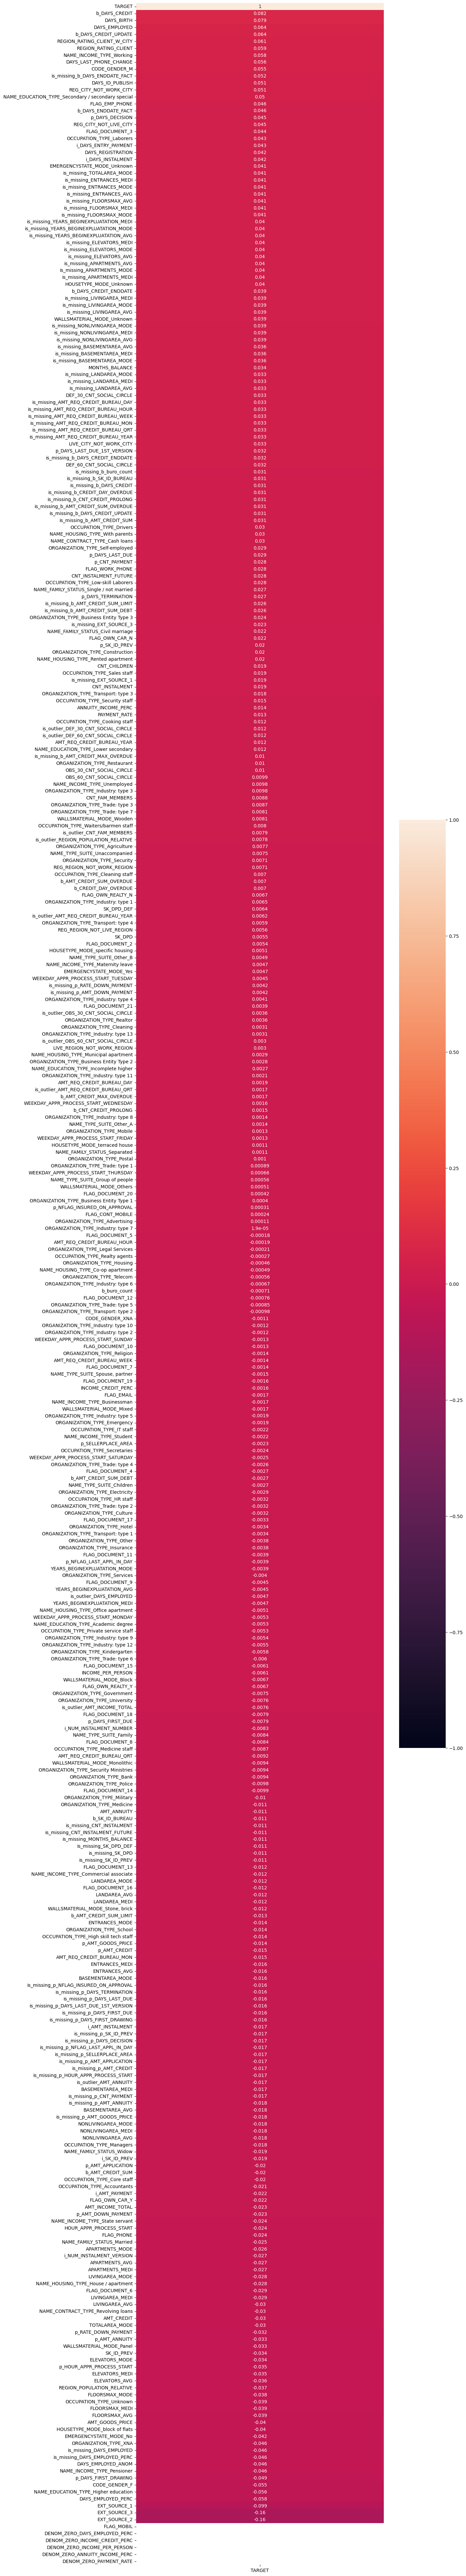

In [20]:
if RUN_LEGACY_PREPROCESSING:
    plt.figure(figsize=(12, 100))
    heatmap = sns.heatmap(trainX_f.corr()[['TARGET']].sort_values(by='TARGET', ascending=False),
                                           vmin=-1, vmax=1, annot=True)
    


In [21]:
# Display correlations
corr_source = df_final[df_final["is_train"] == 1].copy() if "is_train" in df_final.columns else df_final.copy()
numeric_cols = corr_source.select_dtypes(include=["number"]).columns
if "TARGET" in numeric_cols:
    correlations = corr_source[numeric_cols].corr()["TARGET"].sort_values()
else:
    correlations = pd.Series(dtype=float)
print('Most Positive Correlations:\n', correlations.tail(10))


Most Positive Correlations:
 cc_bal_CNT_DRAWINGS_CURRENT        0.082520
cc_bal_AMT_RECEIVABLE_PRINCIPAL    0.086062
cc_bal_AMT_RECIVABLE               0.086478
cc_bal_AMT_TOTAL_RECEIVABLE        0.086490
cc_bal_AMT_BALANCE                 0.087177
b_DAYS_CREDIT                      0.089729
cc_bal_CNT_DRAWINGS_ATM_CURRENT    0.107692
TARGET                             1.000000
is_train                                NaN
is_test                                 NaN
Name: TARGET, dtype: float64


In [22]:
print('\nMost Negative Correlations:\n', correlations.head(10))


Most Negative Correlations:
 EXT_SOURCE_3           -0.178919
EXT_SOURCE_2           -0.160472
EXT_SOURCE_1           -0.155317
cc_bal_SK_ID_PREV      -0.060481
p_DAYS_FIRST_DRAWING   -0.048803
DAYS_EMPLOYED          -0.044932
FLOORSMAX_AVG          -0.044003
FLOORSMAX_MEDI         -0.043768
FLOORSMAX_MODE         -0.043226
AMT_GOODS_PRICE        -0.039645
Name: TARGET, dtype: float64


## Spliting data into training and validation sets

#### Spiting Initial data

In [23]:
if RUN_LEGACY_PREPROCESSING:
    X = trainX_i.drop("TARGET", axis=1)
    y = trainy_i.values.ravel()
    
    seed = 42
    
    # Split. into train and test set 
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                       random_state=seed, stratify=y)
    
    X_train_i.shape, X_test_i.shape, y_train_i.shape, y_test_i.shape


#### Spliting final data

In [24]:
if RUN_LEGACY_PREPROCESSING:
    X = trainX_f.drop("TARGET", axis=1)
    y = trainy_f.values.ravel()
    
    seed = 42
    
    # Split. into train and test set 
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                       random_state=seed, stratify=y)
    
    X_train_f.shape, X_test_f.shape, y_train_f.shape, y_test_f.shape


## Modeling

### Defining Evaluation Metrics

In [25]:
def evaluation_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }
    report = classification_report(y_test, y_pred, zero_division=0)
    mat = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, f1, metrics_dict, report, mat

def evaluation_function(model, X_test, y_test):

    accuracy, precision, recall, f1_score, metrics, report, mat = evaluation_metrics(model, X_test, y_test)
 
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, y_pred)  # fallback if no proba
    
    print('AUC : %0.4f\n' %roc_auc)
    print("Classification report:\n", report)   
    print("Evaluation metrics:\n", metrics)
    print("\n")
    print("Confusion Matrix\n", mat)

def evaluation(model, X_test, y_test):
    return evaluation_function(model, X_test, y_test)



In [26]:
def tunned_learning_curve(model, X_train, y_train):
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    
    with timer("Model learning"): 
        N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              cv=5, scoring="accuracy",
                                              train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 5))
    plt.plot(N, train_score.mean(axis=1), label="train score")
    plt.plot(N, val_score.mean(axis=1), label="validation score")
    plt.legend()

### Baseline Model

In [27]:
# Disable MLflow autologging for exploratory comparisons
mlflow.autolog(disable=True)


In [28]:
if RUN_LEGACY_PREPROCESSING:
    np.random.seed(42)

    # Instancier un modele
    dummy_clf_model = DummyClassifier()

    # Entraîner le pipeline modele
    dummy_clf_model.fit(X_train_i, y_train_i)


#### Baseline Logistic Regression Model 

In [29]:
if RUN_LEGACY_PREPROCESSING:
    np.random.seed(42)

    # Instancier un modele
    log_reg_model_0 = LogisticRegression()

    # Entraîner le pipeline modele
    log_reg_model_0.fit(X_train_i, y_train_i)


## Model Training on various models

We can train a set of models on the churn dataset and compare their performance. To simplify this process, we will use the sklearn library and utilize the model.fit() api to train the model while recording train and test accuracy. The following models are trained:

- Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosted Tree
- Multilayer Perceptron

In [30]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [31]:
def custom_score(y_true, y_pred) :
    '''
        Cost function to minimize the risk for the
        loaning firm.
    
        Parameters
        --------
        - y_true : pandas dataframe
                   The true values of the target
        - y_pred : pandas dataframe
                   The predicted values for the target
            
        Returns
        --------
        - score : float
                  The score for the prediction
    '''

    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # Setting the bank's gain and loss for each case
    FN_value = -10   # The loan is granted but the customer defaults : the bank loses money (Type-II Error)
    TN_value = 1     # The loan is reimbursed : the bank makes money
    TP_value = 0     # The loan is (rightly) refused : the bank neither wins nor loses money
    FP_value = -1    # Loan is refused by mistake : the bank loses money it could have made, 
                     # but does not actually lose any money (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    
    return score  

In [32]:
def optimize_threshold(y_true, y_proba, thresholds=None):
    y_true = np.ravel(y_true)
    if thresholds is None:
        thresholds = np.arange(0.1, 0.91, 0.05)
    scores = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        scores.append(custom_score(y_true, y_pred))
    results = pd.DataFrame({"threshold": thresholds, "custom_score": scores})
    best_idx = results["custom_score"].idxmax()
    best_threshold = float(results.loc[best_idx, "threshold"])
    return results, best_threshold


In [33]:
def train_model(model, X_train, X_test, y_train, y_test):

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test)

    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score_f1 = f1_score(y_test, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, y_pred)

    y_true = np.ravel(y_test)
    best_threshold = None
    if y_pred_proba is not None:
        y_train_proba = pipe.predict_proba(X_train)[:, 1]
        _, best_threshold = optimize_threshold(np.ravel(y_train), y_train_proba)
        y_pred_custom = (y_pred_proba[:, 1] >= best_threshold).astype(int)
        custom = custom_score(y_true, y_pred_custom)
    else:
        custom = custom_score(y_true, y_pred)

    cm_list = []
    cm_list.append(confusion_matrix(y_test, y_pred))

    model_details = {"name": model["name"],
                     "train_accuracy":train_accuracy,
                     "test_accuracy":test_accuracy,
                     "precision": round(precision * 100, 2),
                     "recall": round(recall * 100, 2),
                     "f1_score": round(score_f1 * 100, 2),
                     'AUC':round(roc_auc, 4),
                     "custom_score": round(custom, 4),
                     "best_threshold": best_threshold,
                     "train_time": train_time,
                     "model": pipe}
    return model_details


#### Training and running the models

In [34]:
if RUN_FULL_BENCHMARK:
    # Models to train
    models = [
        {"name": "Baseline classifier", "clf": DummyClassifier()},
        {"name": "Naive Bayes", "clf": GaussianNB()},
        {"name": "Logistic Regression", "clf": LogisticRegression(max_iter=1000)},
        {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
        {"name": "Random Forest", "clf": RandomForestClassifier()},
        {"name": "Hist Gradient Boosting", "clf": HistGradientBoostingClassifier()},
        {"name": "LGBM Classifier", "clf": LGBMClassifier()},
        {"name": "XGB Classifier", "clf": XGBClassifier()},
    ]


In [35]:
if RUN_FULL_BENCHMARK:
    # 8 minutes 47
    trained_models = [] #  keep track of all details for models we train
    
    for model in models:
        with timer(f"running {model}"):
            model_details = train_model(model, X_train_i, X_test_i, y_train_i, y_test_i) 


running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 1s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 4s
running {'name': 'Logistic Regression', 'clf': LogisticRegression(max_iter=1000)} - done in 7s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 20s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 72s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 15s
[LightGBM] [Info] Number of positive: 17267, number of negative: 195904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10216
[LightGBM] [Info] Number of data points in the train set: 213171, number of used features: 271
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081001 -> initscore=-2

In [36]:
if RUN_FULL_BENCHMARK:
    for i in range(len(trained_models)):
        print(f"{trained_models[i]['name']} - custom_score: {trained_models[i]['custom_score']} - AUC: {trained_models[i]['AUC']}")


In [37]:
def train_model(model, X_train, X_test, y_train, y_test):

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test)

    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score_f1 = f1_score(y_test, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, y_pred)

    y_true = np.ravel(y_test)
    best_threshold = None
    if y_pred_proba is not None:
        y_train_proba = pipe.predict_proba(X_train)[:, 1]
        _, best_threshold = optimize_threshold(np.ravel(y_train), y_train_proba)
        y_pred_custom = (y_pred_proba[:, 1] >= best_threshold).astype(int)
        custom = custom_score(y_true, y_pred_custom)
    else:
        custom = custom_score(y_true, y_pred)

    cm_list = []
    cm_list.append(confusion_matrix(y_test, y_pred))

    model_details = {"name": model["name"],
                     "train_accuracy":train_accuracy,
                     "test_accuracy":test_accuracy,
                     "precision": round(precision * 100, 2),
                     "recall": round(recall * 100, 2),
                     "f1_score": round(score_f1 * 100, 2),
                     'AUC':round(roc_auc, 4),
                     "custom_score": round(custom, 4),
                     "best_threshold": best_threshold,
                     "train_time": train_time,
                     "model": pipe}
    return model_details


### Visualizing Custom Score and Run time

In [38]:
if RUN_FULL_BENCHMARK:
    # visualize custom_score and run time
    setup_plot()

    def _ensure_name_column(df):
        if "name" in df.columns:
            return df
        if "Model" in df.columns:
            return df.rename(columns={"Model": "name"})
        if "model" in df.columns:
            return df.rename(columns={"model": "name"})
        df = df.copy()
        df["name"] = df.index.astype(str)
        return df

    def _plot_metrics(model_df, sort_col, metric_cols, title):
        metric_cols = [c for c in metric_cols if c in model_df.columns]
        if not metric_cols:
            print("No metrics to plot. Available:", list(model_df.columns))
            return None
        plot_df = model_df[metric_cols + ["name"]].copy()
        plot_df[metric_cols] = plot_df[metric_cols].apply(pd.to_numeric, errors="coerce")
        metric_cols = [c for c in metric_cols if plot_df[c].notna().any()]
        if not metric_cols:
            print("No numeric metrics to plot after coercion.")
            return None
        if sort_col in plot_df.columns:
            plot_df.sort_values(sort_col, ascending=False, inplace=True)
        ax = plot_df[metric_cols + ["name"]].plot(
            kind="line",
            x="name",
            figsize=(19, 5),
            title=title,
        )
        ax.legend(metric_cols)
        return ax

    if "trained_models_cv" in globals():
        model_df = pd.DataFrame(trained_models_cv)
        model_df = _ensure_name_column(model_df)
        if "cv_custom_score" in model_df.columns:
            ax = _plot_metrics(
                model_df,
                sort_col="cv_custom_score",
                metric_cols=["cv_custom_score", "cv_auc"],
                title="Classifier Perf. Sorted by CV custom_score",
            )
        else:
            fallback = "cv_auc" if "cv_auc" in model_df.columns else "cv_accuracy"
            print("cv_custom_score missing: re-run CV to include it. Using", fallback)
            ax = _plot_metrics(
                model_df,
                sort_col=fallback,
                metric_cols=[fallback],
                title="Classifier Perf. Sorted by CV metric (fallback)",
            )
    else:
        model_df = pd.DataFrame(trained_models)
        model_df = _ensure_name_column(model_df)
        if "custom_score" in model_df.columns:
            ax = _plot_metrics(
                model_df,
                sort_col="custom_score",
                metric_cols=["custom_score", "AUC"],
                title="Classifier Perf. Sorted by Val. custom_score",
            )
        else:
            fallback = "AUC" if "AUC" in model_df.columns else "test_accuracy"
            print("custom_score missing: re-run training to include it. Using", fallback)
            ax = _plot_metrics(
                model_df,
                sort_col=fallback,
                metric_cols=[fallback],
                title="Classifier Perf. Sorted by Val. metric (fallback)",
            )

    if ax is not None:
        for p in ax.patches:
            ax.annotate(
                str(round(p.get_height(), 3)),
                (p.get_x() * 1.005, p.get_height() * 1.005),
            )

        ax.title.set_size(20)
        plt.box(True)

    if "train_time" in model_df.columns:
        model_df["train_time"] = pd.to_numeric(model_df["train_time"], errors="coerce")
        if model_df["train_time"].notna().any():
            model_df.sort_values("train_time", inplace=True)
            ax = model_df[["train_time", "name"]].plot(
                kind="line",
                x="name",
                figsize=(19, 5),
                grid=True,
                title="Classifier Training Time (seconds)",
            )
            ax.title.set_size(20)
            ax.legend(["Train Time"])
            plt.box(False)
        else:
            print("train_time is missing or non-numeric; skipping plot.")


custom_score missing: re-run training to include it. Using test_accuracy
No metrics to plot. Available: ['name']


### Explanations via Feature Importance Scores [Tree Based Models]

In [39]:
if RUN_FULL_BENCHMARK:
    #@title
    
    current_data = trainX_i
    
    # Create array of tree based models and plot feature importance scores
    tree_models = []
    setup_plot()
    color_list =  sns.color_palette("dark", len(current_data.columns)) 
    top_x = 30 # number of x most important features to show
    
    
    for model in trained_models:
        if hasattr(model["model"]["clf"], 'feature_importances_'): 
            tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_}) 
    
    if not tree_models:
        print("No tree-based models with feature_importances_ found.")
    else:
        n_models = len(tree_models)
        fig, axs = plt.subplots(1, n_models, figsize=(10 * n_models, 15), facecolor='w', edgecolor='k')
        if n_models == 1:
            axs = [axs]
        fig.subplots_adjust(hspace = 0.5, wspace=0.8)
        axs = list(axs)
        for i in range(n_models):
            feature_importance = tree_models[i]["fi"]
            indices = np.argsort(feature_importance)
            indices = indices[-top_x:]
    
            bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center') 
            axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)
    
            plt.sca(axs[i])
            plt.yticks(range(len(indices)), [current_data.columns[j] for j in indices], fontweight="normal", fontsize=16) 
    
            for j, ticklabel in enumerate(plt.gca().get_yticklabels()):
                ticklabel.set_color(color_list[indices[j]])  
    
            for j, bar in enumerate(bars):
                bar.set_color(color_list[indices[j]])
            plt.box(False)
    
        plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", 
                     fontsize=20, fontweight="normal")


No tree-based models with feature_importances_ found.


### Features importance for linear mode  .coef_

In [40]:
if RUN_FULL_BENCHMARK:
    plt.figure(figsize=(25, 12))

    current_data = trainX_i if "trainX_i" in globals() else trainX

    log_reg_entry = next(
        (
            m
            for m in trained_models
            if "logistic" in m.get("name", "").lower()
        ),
        None,
    )
    if log_reg_entry is None:
        print("LogisticRegression model not found in trained_models; skip plot.")
    else:
        pipe = log_reg_entry.get("model")
        clf = pipe.named_steps.get("clf") if hasattr(pipe, "named_steps") else pipe
        if not hasattr(clf, "coef_"):
            print("Selected model has no coef_; skip plot.")
        else:
            logistic_reg_coeff = clf.coef_[0]
            if len(logistic_reg_coeff) != len(current_data.columns):
                print(
                    "Coefficient length mismatch:",
                    len(logistic_reg_coeff),
                    "coef vs",
                    len(current_data.columns),
                    "columns",
                )
            else:
                color_list = sns.color_palette("dark", len(current_data.columns))

                top_x = 30
                idx = np.argsort(np.abs(logistic_reg_coeff))[::-1]
                lreg_ax = plt.barh(
                    current_data.columns[idx[:top_x]][::-1],
                    logistic_reg_coeff[idx[:top_x]][::-1],
                )
                for i, bar in enumerate(lreg_ax):
                    bar.set_color(color_list[idx[:top_x][::-1][i]])
                    plt.box(False)

                plt.suptitle(
                    "Logistic Regression. Top " + str(top_x) + " Coefficients.",
                    fontsize=20,
                    fontweight="normal",
                )
                plt.show()


LogisticRegression model not found in trained_models; skip plot.


<Figure size 2500x1200 with 0 Axes>

### Model Explanations with LIME

L'explication indépendante du modèle interprétable local (**LIME**) fournit une méthode rapide et relativement simple pour expliquer localement les modèles de boîte noire. L'**algorithme LIME** peut être simplifié en quelques étapes : 

- Pour un point de données donné, perturbons de manière aléatoire ses caractéristiques à plusieurs reprises. Pour les données tabulaires, cela implique d'ajouter une petite quantité de bruit à chaque entité.
- Nous obtenons des prédictions pour chaque instance de données perturbée. Cela nous aide à construire une image locale de la surface de décision à ce point.
-  Utilisons par la suite les prédictions obtenus pour calculer un `"modèle d'explication" linéaire approximatif` à l'aide de prédictions. Les coefficients du modèle linéaire sont utilisés comme explications.

La bibliothèque python LIME fournit des interfaces pour expliquer les modèles construits sur des `données tabulaires (TabularExplainer), image (LimeImageExplainer) et texte (LimeTextExplainer)`.

Dans la section suivante, nous tenterons d'expliquer les prédictions à partir d'une seule instance de données de test pour tous nos modèles entraînés à l'aide de **LimeTabularExplainer**

#### LIME Tabular Explainer: Explain a test data instance for all models


Dans la section suivante, nous allons générer et visualiser les `explications lime` pour un point de données donné dans notre dataset de test. Nous le ferons pour tous nos modèles entraînés.

In [41]:
if RUN_LEGACY_PREPROCESSING:
    #X_train, X_test, y_train, y_test = train_test_split(current_data, labels, random_state=42) 
    #X = current_data & y = labels
    
    current_data = trainX_i.drop("TARGET", axis=1) 
    labels = trainy_i
    
    from sklearn.model_selection import train_test_split
    
    X = trainX_i.drop("TARGET", axis=1)
    y = trainy_i.values.ravel()
    
    seed = 42
    
    # Split. into train and test set 
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
    
    X_train_i.shape, X_test_i.shape, y_train_i.shape, y_test_i.shape


In [42]:
#current_data.head()
#labels

In [43]:
def get_lime_explainer(model, data, labels):  
    
    cat_feat_ix = [i for i,c in enumerate(data.columns) if pd.api.types.is_categorical_dtype(data[c])]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    scaler = model["model"]["scaler"]
    #data = scaler.transform(data) # scale data to reflect train time scaling
    data_np = data.to_numpy()
    lime_explainer = LimeTabularExplainer(data_np,
                                      feature_names=feat_names,
                                      class_names=class_names,
                                      categorical_features=cat_feat_ix ,
                                      mode="classification"
                                      )
    return lime_explainer


def lime_explain(explainer, data, predict_method, num_features): 
    instance = data.to_numpy() if hasattr(data, "to_numpy") else np.asarray(data)
    instance = instance.reshape(-1)
    explanation = explainer.explain_instance(instance, predict_method, num_features=num_features) 
    return explanation



In [44]:
if RUN_LEGACY_PREPROCESSING:
    pass


In [45]:
if RUN_FULL_BENCHMARK:
    # 1 minute 50
    lime_data_explainations = []
    lime_metrics = []
    lime_explanation_time = []
    feat_names = list(current_data.columns)
    test_data_index = random.choice(X_test_i.index)
    top_x = 30
    
    for current_model in trained_models[1:]:
        with timer(f"running : {current_model['name']} model lime_explainer"):
            #scaler = current_model["model"]["scaler"]
            #scaled_test_data = scaler.transform(X_test)
            scaled_test_data = X_test_i
            predict_method = current_model["model"]["clf"].predict_proba 
    
            start_time = time.time()
            # explain first sample from test data
            lime_explainer = get_lime_explainer(current_model, 
                                            current_data, 
                                            labels)
            explanation = lime_explain(lime_explainer, scaled_test_data.loc[test_data_index], predict_method, top_x) 
            elapsed_time = time.time() - start_time 
    
            ex_holder = {}
            for feat_index,ex in explanation.as_map()[1] :
                ex_holder[feat_names[feat_index]] = ex
      
            lime_data_explainations.append(ex_holder)                          #y = trainy_i.values.reshape(-1,1)
            actual_pred = predict_method(scaled_test_data.loc[test_data_index].values.reshape(1,-1))
            perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])   
            lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })
            lime_metrics.append({"lime class1": explanation.local_pred[0], "actual class1": actual_pred[0][1],
                             "class_diff": round(perc_pred_diff,3), "model": current_model["name"] })


In [46]:
def plot_lime_exp(fig, nrows, ncols, index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(nrows, ncols, index)
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)


In [47]:
if RUN_FULL_BENCHMARK:
    if "lime_data_explainations" not in globals() or "lime_explanation_time" not in globals():
        print("LIME data not available; run the LIME generation cell first.")
    else:
        fig = plt.figure(figsize=(30, 20))

        # Plot lime explanations for trained models
        lime_items = list(zip(lime_data_explainations, trained_models[1:]))
        cols = 3
        rows = max(1, (len(lime_items) + cols - 1) // cols)

        if not lime_items:
            print("No LIME explanations to plot.")
        else:
            for i, (exp_data, model_info) in enumerate(lime_items):
                plot_lime_exp(fig, rows, cols, i + 1, exp_data, model_info["name"])

            title_top_x = top_x if "top_x" in globals() else 30
            plt.suptitle(
                " LIME Explanation for single test data instance.  Top " + str(title_top_x) + " Features",
                fontsize=20,
                fontweight="normal",
            )
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Plot run time for explanations
        lx_df = pd.DataFrame(lime_explanation_time)
        if lx_df.empty or "time" not in lx_df.columns:
            print("LIME runtime data missing; skip runtime plot.")
        else:
            lx_df["time"] = pd.to_numeric(lx_df["time"], errors="coerce")
            lx_df = lx_df[lx_df["time"].notna()]
            if lx_df.empty:
                print("LIME runtime data has no numeric values; skip runtime plot.")
            else:
                lx_df.sort_values("time", inplace=True)
                setup_plot()
                lx_ax = lx_df.plot(
                    kind="line",
                    x="model",
                    title="Runtime (seconds) for single test data instance LIME explanation",
                    figsize=(30, 5),
                )
                lx_ax.title.set_size(20)
                lx_ax.legend(["Run time"])
                plt.box(False)


No LIME explanations to plot.
LIME runtime data missing; skip runtime plot.


<Figure size 3000x2000 with 0 Axes>

#### Debugging  LIME: Should I trust the Explanation?

Sous le capot, l'algorithme LIME utilise un modèle linéaire approximatif pour dériver des explications locales. Comme tout autre modèle ML, ce modèle d'explication peut également avoir des *problèmes*. 
> Alors, que pouvons-nous faire pour renforcer la confiance dans la qualité d'une explication ? 

Dans un premier temps, nous pouvons vérifier si le modèle local est bien un bon approximateur du modèle original.

In [48]:
if RUN_FULL_BENCHMARK:
    # Plot run time for explanations
    lime_metrics_df = pd.DataFrame(lime_metrics)
    expected_cols = ["lime class1", "actual class1", "model"]
    if lime_metrics_df.empty or not set(expected_cols).issubset(lime_metrics_df.columns):
        print("LIME metrics not available; run the LIME generation cell first.")
    else:
        lime_metrics_df["lime class1"] = pd.to_numeric(lime_metrics_df["lime class1"], errors="coerce")
        lime_metrics_df["actual class1"] = pd.to_numeric(lime_metrics_df["actual class1"], errors="coerce")
        lime_metrics_df = lime_metrics_df.dropna(subset=["lime class1", "actual class1"])
        if lime_metrics_df.empty:
            print("LIME metrics are non-numeric; skip plot.")
        else:
            lime_metrics_df_ax = lime_metrics_df[expected_cols].plot(
                kind="line",
                x="model",
                title="LIME Actual Prediction vs Local Prediction",
                figsize=(22, 6),
            )
            lime_metrics_df_ax.title.set_size(20)
            lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])


LIME metrics not available; run the LIME generation cell first.


### Model Explanations with SHAP

Les **valeurs Sharley** obtenus fournissent une méthode pour le type spécifique d'allocation (paramètre de jeu multijoueur collaboratif) avec un ensemble de propriétés axiomatiques souhaitables (Efficacité, Symétrie, Linéarité, Anonymat, Marginalisme) qui garantissent l'équité. Ces valeurs sont calculées en calculant la contribution marginale moyenne de chaque personne dans tous les classements possibles.

Pour expliquer notre modèle, nous ajoutons à plusieurs reprises chaque caractéristique et notons sa contribution marginale à la prédiction du modèle. Il est important de noter que nous souhaitons utiliser les **valeurs de Shapley** pour attribuer un crédit à chaque fonctionnalité, car elles fournissent deux garanties importantes (par exemple, LIME, Feature Permutation, Feature Importance) que d'autres méthodes ne fournissent pas :

- La `précision locale` (un modèle approximatif utilisé pour expliquer le modèle d'origine doit correspondre à la sortie du modèle d'origine pour une entrée donnée)
- La `Cohérence` (si le modèle d'origine change de telle sorte qu'une fonctionnalité a un impact plus important dans chaque ordre possible, son attribution ne devrait pas diminuer)

Dans la pratique, quelques simplifications sont nécessaires pour calculer les **valeurs de Shapley**. Le plus important est peut-être lié à la façon dont nous simulons l'ajout ou la suppression de fonctionnalités lors du calcul de la prédiction du modèle. C'est difficile car il n'existe aucun moyen simple de "supprimer" une fonctionnalité pour la plupart des modèles prédictifs au moment du test. On peut soit remplacer la caractéristique par sa valeur moyenne, soit sa valeur médiane. Dans l'implémentation de la bibliothèque SHAP, une entité "manquante" est simulée en remplaçant l'entité par les valeurs qu'elle prend dans le jeu de données d'arrière-plan.

#### The SHAP Library Implementation

The SHAP library contains implementations for several types of explanations that leverage Shapley values. These include the TreeExplainer which is optimized (and fast) for tree based models; DeepExplainer and GradientExplainer for neural networks; and KernelExplainer, which makes no assumptions about the underlying model to be explained (model agnostic like LIME).

To explain a model on a test set using KernelExplainer, the SHAP library api is as follows:

In [49]:
if RUN_FULL_BENCHMARK:
    import shap

    # Example (KernelExplainer):
    # explainer = shap.KernelExplainer(model.predict_proba, background_data)
    # shap_values = explainer.shap_values(X_test)


To unpack and understand the results from SHAP KernelExplainer, there are a few terms worth clarifying.


| Variable 	| Description 	|
|--------------------------	|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| model 	| the model to be explained 	|
| background_data 	| This is a required argument to KernelExplainer. Since most models aren’t designed to handle arbitrary missing data at test time, SHAP simulates a “missing” feature by replacing it with the values it takes in the background dataset. For small problems, this background dataset can be the whole training set, but for larger problems, it is suggested that a subsample of the training set (or the kmeans function to summarize the dataset) is used. Background data is optional for tree-based models. 	|
| explainer.expected_value 	| This is a field in the explainer object is displayed as the baseline in a SHAP force plot. It should be the same as the mean of the model output over the background dataset. One simple task which I found to be useful is to manually compute the mean prediction on the background dataset and see how it corresponds to the expected value output by SHAP. 	|
| shap_values 	| The shap_values returned by the explainer object are a measure of how each feature contributes to the difference between the model’s expected value and the prediction for that instance. The units of the Shapley values are in the units of the target variable. The sum of the shap values should be equal to the difference between the base value and the model prediction. 	|



#### Kernel Explaner for a single model

In [50]:
if RUN_FULL_BENCHMARK:
    import shap

    # Example (KernelExplainer):
    # explainer = shap.KernelExplainer(model.predict_proba, background_data)
    # shap_values = explainer.shap_values(X_test)


In [51]:
if RUN_FULL_BENCHMARK:
    if "clf" in globals() and "subsampled_test_data" in globals():
        print("predict_proba shape:", clf.predict_proba(subsampled_test_data).shape)
        print("classes_:", getattr(clf, "classes_", None))
    else:
        print("clf/subsampled_test_data not available; run SHAP generation cell first.")

    if "shap_values" in globals():
        print("type(shap_values):", type(shap_values))
        if isinstance(shap_values, list):
            print("len(shap_values):", len(shap_values))
            if len(shap_values) > 0:
                print("shape[0]:", shap_values[0].shape)
            if len(shap_values) > 1:
                print("shape[1]:", shap_values[1].shape)
        else:
            print("shap_values shape:", shap_values.shape)
    else:
        print("shap_values not available; run SHAP generation cell first.")

    if "explainer" in globals():
        print("expected_value:", explainer.expected_value)
    else:
        print("explainer not available; run SHAP generation cell first.")


clf/subsampled_test_data not available; run SHAP generation cell first.
shap_values not available; run SHAP generation cell first.
explainer not available; run SHAP generation cell first.


In [52]:
if RUN_FULL_BENCHMARK:
    shap.initjs()


#### Kernel Explainer - Explain a test data instance for all models

In the following section, we will generate and visualize explanations using the SHAP KernelExplainer for a given data point in our test set (same as we did for LIME). 

In [53]:
if RUN_FULL_BENCHMARK:
    import shap

    # Example (KernelExplainer):
    # explainer = shap.KernelExplainer(model.predict_proba, background_data)
    # shap_values = explainer.shap_values(X_test)


In [54]:
if RUN_FULL_BENCHMARK:
    shap_data_explainations = []
    shape_explanation_time = []
    
    feat_names = list(current_data.columns)
    test_data_index = random.choice(X_test_i.index)
    top_x = 30
    
    for current_model in trained_models[1:]:
        with timer(f"running : {current_model['name']} model shap_explainer"):
            clf = current_model["model"]["clf"]
            #scaler = current_model["model"]["scaler"]
            #scaled_train_data = scaler.transform(X_train_i)
            scaled_train_data = X_train_i
    
            sub_sampled_train_data = shap.sample(scaled_train_data, 600, random_state=0)
    
            #scaled_test_data = scaler.transform(X_test)
            scaled_test_data = X_test_i
            sampled_scaled_test_data = scaled_test_data.loc[test_data_index].values.reshape(1, -1)
    
            start_time = time.time()
            shap_explainer = get_kernel_shap_explainer(clf, sub_sampled_train_data, scaled_train_data)
            shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
            elapsed_time = time.time() - start_time
    
            # choisir la classe (1 = defaut)
            class_idx = 1
            if isinstance(shap_values, list):
                vals = shap_values[class_idx][0] if len(shap_values) > 1 else shap_values[0][0]
            else:
                # ndarray: (n_samples, n_features, n_classes)
                if shap_values.ndim == 3:
                    vals = shap_values[0, :, class_idx]
                else:
                    vals = shap_values[0]
    
            idx = np.argsort(np.abs(vals))[::-1]
            top_k = min(top_x, len(idx))
            ex_holder = {feat_names[idx[i]]: vals[idx[i]] for i in range(top_k)}
    
            shap_data_explainations.append(ex_holder)
            shape_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})


In [55]:
def plot_shap_exp(fig, fig_index, exp_data, title):
    features =  list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(fig_index) 
    lime_bar = ax.barh( features, explanations ) 
    ax.set_title(title, fontsize = 20)
    for i,bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False) 

In [56]:
if RUN_FULL_BENCHMARK:
    if "shap_data_explainations" not in globals() or "shape_explanation_time" not in globals():
        print("SHAP data not available; run the SHAP generation cell first.")
    else:
        # Plot SHAP explanations for a given test set item
        fig = plt.figure(figsize=(30, 20))

        shap_items = list(zip(shap_data_explainations, trained_models[1:]))
        cols = 3
        rows = max(1, (len(shap_items) + cols - 1) // cols)

        if not shap_items:
            print("No SHAP explanations to plot.")
        else:
            for i, (exp_data, model_info) in enumerate(shap_items):
                plot_lime_exp(fig, rows, cols, i + 1, exp_data, model_info["name"])

            title_top_x = top_x if "top_x" in globals() else 30
            plt.suptitle(
                "Kernel SHAP Explanation for single test data instance.  Top "
                + str(title_top_x)
                + " Features",
                fontsize=20,
                fontweight="normal",
            )
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Plot SHAP explanation run time
        shapx_df = pd.DataFrame(shape_explanation_time)
        if shapx_df.empty or "time" not in shapx_df.columns:
            print("SHAP runtime data missing; skip runtime plots.")
            shapx_df = None
        else:
            shapx_df["time"] = pd.to_numeric(shapx_df["time"], errors="coerce")
            shapx_df = shapx_df[shapx_df["time"].notna()]
            if shapx_df.empty:
                print("SHAP runtime data has no numeric values; skip runtime plots.")
                shapx_df = None
            else:
                shapx_df.sort_values("time", inplace=True)

        # Plot both LIME and SHAP explanation run times
        if shapx_df is not None and "lx_df" in globals():
            if "time" in lx_df.columns:
                lx_df["time"] = pd.to_numeric(lx_df["time"], errors="coerce")
                lx_df_clean = lx_df[lx_df["time"].notna()]
            else:
                lx_df_clean = None

            if lx_df_clean is None or lx_df_clean.empty:
                print("LIME runtime data missing; skip SHAP vs LIME plot.")
            else:
                m_df = shapx_df.merge(lx_df_clean, on="model", suffixes=("_SHAP", "_LIME"))
                if m_df.empty:
                    print("No overlap between SHAP and LIME runtime data; skip plot.")
                else:
                    mx_df_ax = m_df.plot(
                        kind="line",
                        x="model",
                        title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation",
                        figsize=(22, 6),
                    )
                    mx_df_ax.title.set_size(20)
                    mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
                    plt.box(False)
        else:
            print("LIME runtime data not available; skip SHAP vs LIME plot.")


No SHAP explanations to plot.
SHAP runtime data missing; skip runtime plots.
LIME runtime data not available; skip SHAP vs LIME plot.


<Figure size 3000x2000 with 0 Axes>

### Models Confusion Matrix - Heatmap

In [57]:
if RUN_FULL_BENCHMARK:
    model_list = []
    
    for i in range(len(trained_models)):
        #print(f"{trained_models[i]['name']} - AUC: {trained_models[i]['AUC']}")
        model_list.append(trained_models[i]['name'])


In [58]:
if RUN_FULL_BENCHMARK:
    models_list = [trained_models[i]['model']['clf'] for i in range(len(trained_models))]
    models_list
    


In [59]:
if RUN_FULL_BENCHMARK:
    models_pipeline = models_list


In [60]:
if RUN_FULL_BENCHMARK:
    import re
    
    model_list = [trained_models[i]['name'] for i in range(len(trained_models))]
    acc_list = [trained_models[i]['train_accuracy'] for i in range(len(trained_models))]
    auc_list = [trained_models[i]['AUC'] for i in range(len(trained_models))]
    models_pipeline = [trained_models[i]['model']['clf'] for i in range(len(trained_models))]
    #models_pipeline = models_list
    
    
    def _sanitize_feature_names(df):
        if not hasattr(df, "columns"):
            return df
        cols = []
        seen = {}
        for c in df.columns:
            base = re.sub(r"[^0-9A-Za-z_]+", "_", str(c))
            seen[base] = seen.get(base, 0) + 1
            cols.append(base if seen[base] == 1 else f"{base}_{seen[base]}")
        out = df.copy()
        out.columns = cols
        return out
    
    
    X_train_i_lgbm = _sanitize_feature_names(X_train_i)
    X_test_i_lgbm = _sanitize_feature_names(X_test_i)
    
    cm_list = []
    
    for model in models_pipeline:
        with timer(f"running {model}"):
            if model.__class__.__name__ == "LGBMClassifier":
                X_train_use, X_test_use = X_train_i_lgbm, X_test_i_lgbm
            else:
                X_train_use, X_test_use = X_train_i, X_test_i
            model.fit(X_train_use, y_train_i)
            y_pred = model.predict(X_test_use)
            acc_list.append(metrics.accuracy_score(y_test_i, y_pred))
            fpr, tpr, _thresholds = metrics.roc_curve(y_test_i, y_pred)
            auc_list.append(round(metrics.auc(fpr, tpr), 2))
            cm_list.append(confusion_matrix(y_test_i, y_pred))


In [61]:
if RUN_FULL_BENCHMARK:
    cm_list_copy = cm_list[1:]
    model_list_copy = model_list[1:]
    cm_list_copy


In [62]:
# cm_list_copy/model_list_copy exclude the baseline model


In [63]:
if RUN_FULL_BENCHMARK:
    for i in range(len(cm_list_copy)):
        print(cm_list_copy[i], "\n")


In [64]:
if RUN_FULL_BENCHMARK:
    ## plot confusion matrix
    cols = 3
    rows = max(1, (len(cm_list_copy) + cols - 1) // cols)
    fig = plt.figure(figsize=(10 * cols, 5 * rows))
    
    for i, (cm, model) in enumerate(zip(cm_list_copy, model_list_copy)):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(model)
        cm_plot = sns.heatmap(cm, annot=True, cmap="Blues_r", ax=ax)
        cm_plot.set_xlabel("Predicted Values")
        cm_plot.set_ylabel("Actual Values")
    
    fig.tight_layout()


<Figure size 3000x500 with 0 Axes>

In [65]:
if RUN_FULL_BENCHMARK:
    model_list = [trained_models[i]['name'] for i in range(len(trained_models))]
    acc_list = [trained_models[i]['train_accuracy'] for i in range(len(trained_models))]
    precision_list = [trained_models[i]['precision'] for i in range(len(trained_models))]
    recall_list = [trained_models[i]['recall'] for i in range(len(trained_models))]
    f1_score_list = [trained_models[i]['f1_score'] for i in range(len(trained_models))]
    auc_list = [trained_models[i]['AUC'] for i in range(len(trained_models))]
    custom_score_list = [trained_models[i]['custom_score'] for i in range(len(trained_models))]
    best_threshold_list = [trained_models[i]['best_threshold'] for i in range(len(trained_models))]
    train_time_list = [trained_models[i]['train_time'] for i in range(len(trained_models))]
    
    result_df = pd.DataFrame({"Model": model_list,
                              "custom_score": custom_score_list,
                              "best_threshold": best_threshold_list,
                              "AUC": auc_list,
                              "Accuracy": acc_list,
                              "precision": precision_list,
                              "recall": recall_list,
                              "f1_score": f1_score_list,
                              "train_time": train_time_list})
    result_df = result_df.sort_values(by='custom_score', ascending=False)
    result_df


### Utilisation du jeu de données avec plus de features

In [66]:
if RUN_FULL_BENCHMARK:
    # 3 minutes 33 secondes
    trained_models_moreFeatures = [] #  keep track of all details for models we train
    
    for model in models:
        with timer(f"running {model}"):
            model_details = train_model(model, X_train_f, X_test_f, y_train_f, y_test_f) 


running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 2s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 5s
running {'name': 'Logistic Regression', 'clf': LogisticRegression(max_iter=1000)} - done in 6s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 40s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 111s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 19s
[LightGBM] [Info] Number of positive: 17267, number of negative: 195904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20254
[LightGBM] [Info] Number of data points in the train set: 213171, number of used features: 352
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081001 -> initscore=-

In [67]:
def trained_models_results(trained_models):
    model_list = [trained_models[i]['name'] for i in range(len(trained_models))]
    acc_list = [trained_models[i]['train_accuracy'] for i in range(len(trained_models))]
    precision_list = [trained_models[i]['precision'] for i in range(len(trained_models))]
    recall_list = [trained_models[i]['recall'] for i in range(len(trained_models))]
    f1_score_list = [trained_models[i]['f1_score'] for i in range(len(trained_models))]
    auc_list = [trained_models[i]['AUC'] for i in range(len(trained_models))]
    custom_score_list = [trained_models[i]['custom_score'] for i in range(len(trained_models))]
    best_threshold_list = [trained_models[i]['best_threshold'] for i in range(len(trained_models))]
    train_time_list = [trained_models[i]['train_time'] for i in range(len(trained_models))]

    result_df = pd.DataFrame({"Model":model_list,
                          "custom_score": custom_score_list,
                          "best_threshold": best_threshold_list,
                          "AUC": auc_list,
                          "Accuracy":acc_list,
                          "precision":precision_list,
                          "recall":recall_list,
                          "f1_score":f1_score_list,
                         "train_time":train_time_list})

    result_df

    return result_df.sort_values(by='custom_score', ascending=False)


In [68]:
if RUN_FULL_BENCHMARK:
    # visualize custom_score and run time
    def visualizing_models_accuracy(trained_models):
        setup_plot()
        model_df = pd.DataFrame(trained_models)
        model_df.sort_values("custom_score", ascending=False, inplace=True)
        ax = model_df[["custom_score", "AUC", "name"]].plot(kind="line",
                                                                   x="name", 
                                                                   figsize=(19,5), 
                                                                   title="Classifier Perf. Sorted by custom_score\n")
        ax.legend(["custom_score", "AUC"])
        for p in ax.patches:
            ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))
    
        ax.title.set_size(20)
        plt.box(True)
    
        model_df.sort_values("train_time", inplace=True)
        ax= model_df[["train_time","name"]].plot(kind="line",
                                             x="name", 
                                             figsize=(19,5), grid=True, 
                                             title="Classifier Training Time (seconds)")
        ax.title.set_size(20)
        ax.legend(["Train Time"])
        plt.box(False) 


## Gestion du problème de déséquilibre de classe

### Utilisation des méthodes de rééchantillonnage 

Nous allons modifier l’ensemble de données utilisé avant d’entraîner le modèle prédictif afin d’avoir des données plus équilibrées. Cette stratégie est appelée rééchantillonnage et il existe deux méthodes principales que vous pouvez utiliser pour égaliser les classes :  Le **sur-échantillonnage** (Oversampling) et le **sous-échantillonnage** (Undersampling).

- Les `méthodes d’Oversampling` fonctionnent en augmentant le nombre d’observations de la (des) classe(s) minoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.

- Les `méthodes d’Undersampling` fonctionnent en diminuant le nombre d’observations de la  (des) classe(s) majoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.

In [69]:
if RUN_LEGACY_PREPROCESSING:
    X_train_resampling = X_train_i.copy()
    X_train_resampling['TARGET'] = y_train_i

    minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
    majority = X_train_resampling[X_train_resampling["TARGET"] == 0]


#### Méthode Sur-echantillonage

In [70]:
if RUN_LEGACY_PREPROCESSING:
    # Resolution du probleme de desequilibre de classe : sur-echantillonnage
    X_train_resampling = X_train_i.copy()
    X_train_resampling["TARGET"] = y_train_i

    minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
    majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

    minority_upsampled = resample(
        minority,
        replace=True,
        n_samples=len(majority),
        random_state=42,
    )
    upsampled = pd.concat([majority, minority_upsampled])

    # Donnees d'entrainement (sur-echantillonnage)
    X_train_up_i = upsampled.drop("TARGET", axis=1)
    y_train_up_i = upsampled["TARGET"]


#### Méthode Sous-echantillonage

In [71]:
if RUN_LEGACY_PREPROCESSING:
    # Resolution du probleme de desequilibre de classe : sous-echantillonnage
    X_train_resampling = X_train_i.copy()
    X_train_resampling["TARGET"] = y_train_i

    minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
    majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=len(minority),
        random_state=42,
    )
    downsampled = pd.concat([minority, majority_downsampled])

    # Donnees d'entrainement (sous-echantillonnage)
    X_train_down_i = downsampled.drop("TARGET", axis=1)
    y_train_down_i = downsampled["TARGET"]


In [72]:
if RUN_LEGACY_PREPROCESSING:
    # Methode de sous-echantillonnage sur jeu de donnees final

    X_train_resampling = X_train_f.copy()
    X_train_resampling["TARGET"] = y_train_f

    minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
    majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

    # Resolution du probleme de desequilibre de classe : sous-echantillonnage
    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=len(minority),
        random_state=42,
    )
    downsampled = pd.concat([minority, majority_downsampled])

    # Donnees d'entrainement (sous-echantillonnage)
    X_train_down_f = downsampled.drop("TARGET", axis=1)
    y_train_down_f = downsampled["TARGET"]


### Re-entrainements des modèle avec jeu de donnée équilibré sur dataset initial

In [73]:
if RUN_FULL_BENCHMARK:
    trained_models_balanced_i = [] #  keep track of all details for models we train
    
    for model in models:
        with timer(f"running {model}"):
            model_details = train_model(model, X_train_down_i, X_test_i, y_train_down_i, y_test_i) 


running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 0s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 1s
running {'name': 'Logistic Regression', 'clf': LogisticRegression(max_iter=1000)} - done in 1s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 3s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 18s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 4s
[LightGBM] [Info] Number of positive: 17267, number of negative: 17267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9868
[LightGBM] [Info] Number of data points in the train set: 34534, number of used features: 258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

In [74]:
if RUN_FULL_BENCHMARK:
    result_df_balanced_i = trained_models_results(trained_models=trained_models_balanced_i)


### Re-entrainements des modèle avec jeu de donnée équilibré sur dataset final

In [75]:
if RUN_FULL_BENCHMARK:
    trained_models_balanced_f = [] #  keep track of all details for models we train
    
    for model in models:
        with timer(f"running {model}"):
            model_details = train_model(model, X_train_down_f, X_test_f, y_train_down_f, y_test_f) 


running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 1s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 1s
running {'name': 'Logistic Regression', 'clf': LogisticRegression(max_iter=1000)} - done in 2s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 4s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 17s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 5s
[LightGBM] [Info] Number of positive: 17267, number of negative: 17267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19632
[LightGBM] [Info] Number of data points in the train set: 34534, number of used features: 339
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0000

In [76]:
if RUN_FULL_BENCHMARK:
    result_df_balanced_f = trained_models_results(trained_models=trained_models_balanced_f)


### Optimisation des hyperparametres- Tunning Hyper-parameters

#### Fine Tuning LogisticRegression model

In [77]:
if RUN_FULL_BENCHMARK:
    # Create a hyper-parameters tunning for LogisticRegression
    log_reg_grid = {"penalty": ["l1", "l2"], "C": np.logspace(-4, 4, 30)}
    # Setup grid hyperparameter search for LogisticRegression
    gs_log_reg_i = GridSearchCV(
        LogisticRegression(),
        param_grid=log_reg_grid,
        cv=5,
        verbose=True,
    )

    with timer("Log_reg model fine_tuning on inial data balanced"):
        gs_log_reg_i.fit(X_train_down_i, y_train_down_i)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Log_reg model fine_tuning on inial data balanced - done in 100s


In [78]:
if RUN_FULL_BENCHMARK:
    gs_log_reg_i


In [79]:
if RUN_FULL_BENCHMARK:
    # Check the best hyperparameters
    gs_log_reg_i.best_params_


In [80]:
if RUN_FULL_BENCHMARK:
    # Create a hyper-parameters tunning for LogisticRegression
    log_reg_grid = {"penalty": ["l1", "l2"], "C": np.logspace(-4, 4, 30)}
    # Setup grid hyperparameter search for LogisticRegression
    gs_log_reg_f = GridSearchCV(
        LogisticRegression(),
        param_grid=log_reg_grid,
        cv=5,
        verbose=True,
    )

    with timer("Log_reg model fine_tuning on final data balanced"):
        gs_log_reg_f.fit(X_train_down_f, y_train_down_f)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Log_reg model fine_tuning on final data balanced - done in 88s


In [81]:
if RUN_FULL_BENCHMARK:
    gs_log_reg_f

In [82]:
# Check the best hyperparameters
if RUN_FULL_BENCHMARK:
    gs_log_reg_f.best_params_

#### Fine Tuning HistGradientBoostingClassifier model

In [83]:
if RUN_FULL_BENCHMARK:
    # 7minutes 11 secondes
    hgb_clf_params = {'learning_rate': [1e-1, 2e-1, 3e-1],
              'max_depth': [2, 4, 5],
              'min_samples_leaf': [30, 31, 32],
              'max_iter': [100, 150]
              }
    
    
    # Setup random hyperparameter search for HistGradientBoostingClassifier
    gs_hgb_clf_f = GridSearchCV(HistGradientBoostingClassifier(),
                                    param_grid=hgb_clf_params,
                                    cv=4,
                                    verbose=True)
    


In [84]:
if RUN_FULL_BENCHMARK:
    if hasattr(gs_hgb_clf_f, "best_params_"):
        gs_hgb_clf_f.best_params_
    else:
        print("GridSearch not fitted yet; run gs_hgb_clf_f.fit(...) first.")


GridSearch not fitted yet; run gs_hgb_clf_f.fit(...) first.


### Best Final Model - HistGradientBoostingClassifier

In [85]:
def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):
    plt.style.use('default')
    
    fig = plt.figure(figsize=size)
    
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_true, y_pred)
    
  
    #plt.subplot(221)
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues_r')
    plt.tick_params(axis='both', which='major', labelsize=10, 
                    labelbottom = False, bottom=False, top = False, labeltop=True)


    #plt.subplot(222)
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba[:,1])    #pour la courbe ROC utilisation de la proba d'être 1
    plt.plot(fpr, tpr, color='blue', linewidth=2, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()


In [86]:
if RUN_LEGACY_PREPROCESSING:
    # train a Random Forest model on the training set
    HistGB_balanced_model_f = HistGradientBoostingClassifier(learning_rate=0.1,
                                                              max_depth=4,
                                                              max_iter=150,
                                                              min_samples_leaf=30
                                                             )
    
    #Fitting our model
    HistGB_balanced_model_f.fit(X_train_down_f, y_train_down_f)


In [87]:
if RUN_LEGACY_PREPROCESSING:
    HistGB_balanced_model_f

In [88]:
if RUN_LEGACY_PREPROCESSING:
    y_pred = HistGB_balanced_model_f.predict(X_test_f)
    y_pred_proba = HistGB_balanced_model_f.predict_proba(X_test_f)
    
    roc_auc = roc_auc_score(y_test_f, y_pred_proba[:, 1])  #on se base sur la probabilité d'être en défaut de paiement
    print('AUC : %0.4f' %roc_auc)


AUC : 0.7691


In [89]:
#np.linspace(0.1, 1, 10)

In [90]:
def tunned_learning_curve(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    with timer("Model learning"): 
        N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              cv=5, scoring="accuracy",
                                              train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 5))
    plt.plot(N, train_score.mean(axis=1), label="train score")
    plt.plot(N, val_score.mean(axis=1), label="validation score")
    plt.legend(loc='best', title='accuracy')  # https://www.statology.org/matplotlib-legend-position/ 
                                                                                    #loc=lower right

Model learning - done in 71s


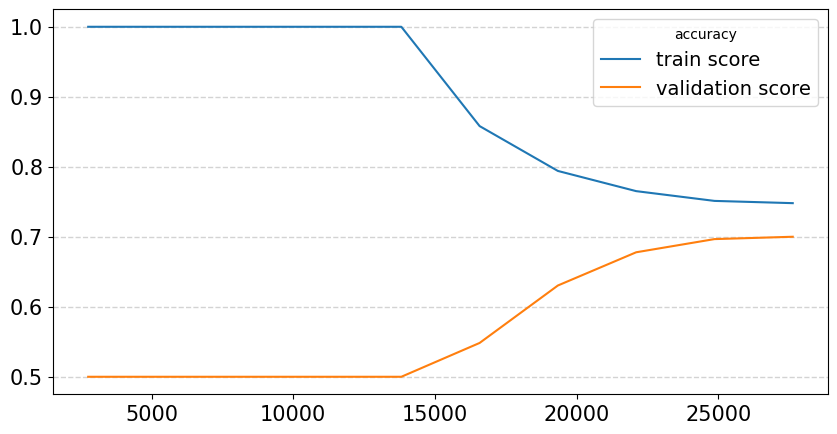

In [91]:
if RUN_LEGACY_PREPROCESSING:
    tunned_learning_curve(
        model=HistGB_balanced_model_f,
        X_train=X_train_down_f,
        y_train=y_train_down_f,
        X_test=X_test_f,
    )


In [92]:
#metrics.get_scorer_names()

### Optimisation du modèle d'un point de vue métier (fonction coût métier)


La problématique « métier » est de prendre en compte qu'un faux positif (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n'a pas le même coût qu'un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est en effet 10 fois plus coûteux qu'un faux positif.

Nous allons définir une fonction métier adaptée au projet qui permet d'attribuer plus de poids à la minimisation des FN.

Ainsi nous allons à nouveau effectuer une nouvelle recherche des hyper-paramètres via HyperOpt se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l'entreprise.



In [93]:
if RUN_LEGACY_PREPROCESSING:
    y_pred = HistGB_balanced_model_f.predict(X_test_f)
    y_pred_proba = HistGB_balanced_model_f.predict_proba(X_test_f)
    
    roc_auc = roc_auc_score(y_test_f, y_pred_proba[:, 1])  #on se base sur la probabilité d'être en défaut de paiement
    print('AUC : %0.4f' %roc_auc)


AUC : 0.7710


Best threshold (custom_score): 0.6500000000000001


,threshold,custom_score
0,0.10,-1.206336
1,0.15,-1.056767
2,0.20,-0.857103
3,0.25,-0.645323
4,0.30,-0.449238
5,0.35,-0.276377
6,0.40,-0.128418
7,0.45,-0.008757
8,0.50,0.083350
9,0.55,0.153136


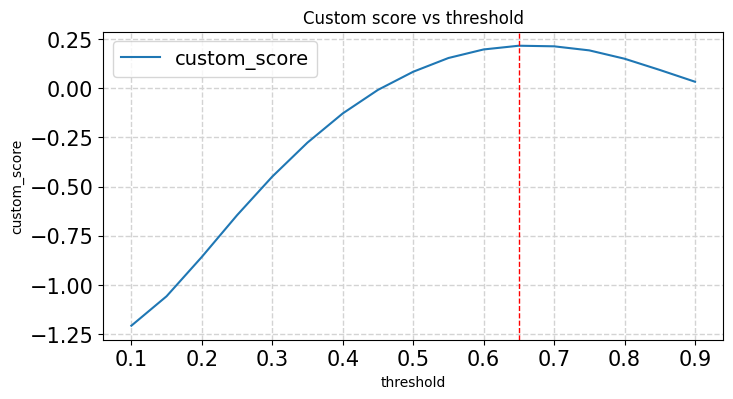

In [94]:
if RUN_LEGACY_PREPROCESSING:
    # Optimisation du seuil metier (exemple sur le modele final)
    X_train_eval = X_train_f.drop("TARGET", axis=1) if "TARGET" in X_train_f.columns else X_train_f
    y_train_proba = HistGB_balanced_model_f.predict_proba(X_train_eval)
    threshold_results, best_threshold = optimize_threshold(y_train_f, y_train_proba[:, 1])
    print("Best threshold (custom_score):", best_threshold)
    display(threshold_results)
    
    ax = threshold_results.plot(x="threshold", y="custom_score", figsize=(8, 4), title="Custom score vs threshold")
    ax.axvline(best_threshold, color="red", linestyle="--", linewidth=1)
    ax.set_ylabel("custom_score")
    plt.show()


In [95]:
import os
from pathlib import Path

for key in ("HTTP_PROXY", "HTTPS_PROXY", "ALL_PROXY"):
    os.environ.pop(key, None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

tracking_uri = os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")
mlflow.set_tracking_uri(tracking_uri)
mlflow.sklearn.autolog(disable=True)

try:
    mlflow.set_experiment("Baseline-Models-v2")
except Exception as exc:
    local_uri = f"file:{Path.cwd() / 'mlruns'}"
    print(f"MLflow tracking URI not reachable: {tracking_uri} ({exc})")
    print(f"Falling back to local store: {local_uri}")
    mlflow.set_tracking_uri(local_uri)
    mlflow.set_experiment("Baseline-Models-v2")


MLflow tracking URI not reachable: http://127.0.0.1:5000 (API request to endpoint /api/2.0/mlflow/experiments/get-by-name failed with error code 403 != 200. Response body: '')
Falling back to local store: file:/Users/steph/Code/Python/Jupyter/OCR_projet06/notebooks/mlruns


In [96]:
def run_and_log_model(run_name, estimator, model_family, notes, X_train, y_train, X_test, y_test, imbalance_method="downsampling", pipeline=None):
    with mlflow.start_run(run_name=run_name):
        mlflow.set_tag("model_family", model_family)
        mlflow.set_tag("dataset", "final_processed")
        mlflow.set_tag("notes", notes)
        mlflow.set_tag("imbalance_method", imbalance_method)

        np.random.seed(42)
        if pipeline is None:
            model = build_pipeline(algo_ml=estimator)
        else:
            model = pipeline

        start_time = time.time()
        model.fit(X_train, y_train)
        train_time_sec = time.time() - start_time
        mlflow.log_metric("train_time_sec", train_time_sec)

        y_test_arr = np.ravel(y_test)
        y_test_preds = model.predict(X_test)

        y_test_proba = None
        if hasattr(model, "predict_proba"):
            y_test_proba = model.predict_proba(X_test)

        if y_test_proba is not None:
            y_train_arr = np.ravel(y_train)
            y_train_proba = model.predict_proba(X_train)[:, 1]
            _, best_threshold = optimize_threshold(y_train_arr, y_train_proba)
            y_prob = y_test_proba[:, 1]
            y_pred_custom = (y_prob >= best_threshold).astype(int)
            custom = custom_score(y_test_arr, y_pred_custom)
            mlflow.log_metric("custom_score", custom)
            mlflow.log_param("best_threshold", float(best_threshold))
            roc_auc = roc_auc_score(y_test_arr, y_prob)
        else:
            custom = custom_score(y_test_arr, y_test_preds)
            mlflow.log_metric("custom_score", custom)
            roc_auc = roc_auc_score(y_test_arr, y_test_preds)

        log_dataset_info(X_train, X_test, y_train, y_test)
        log_estimator_params(model)
        log_preprocessing_feature_count(model)

        accuracy, precision, recall, f1_value, metrics_dict, report, mat = evaluation_metrics(model, X_test, y_test)
        if callable(f1_value):
            f1_value = f1_score(y_test_arr, y_test_preds)
        mlflow.log_metrics({"accuracy": float(accuracy), "precision": float(precision), "recall": float(recall), "f1_score": float(f1_value)})
        mlflow.log_metric("roc_auc", roc_auc)

        mlflow.sklearn.log_model(model, "model")

        print("Evaluation metrics:", metrics_dict)
        print("Model run ID:", mlflow.active_run().info.run_id)


In [97]:
if RUN_LEGACY_PREPROCESSING:
    def sanitize_cols(df):
        cols = []
        seen = {}
        for c in df.columns:
            base = re.sub(r'[^0-9A-Za-z_]+', '_', str(c))
            seen[base] = seen.get(base, 0) + 1
            cols.append(base if seen[base] == 1 else f"{base}_{seen[base]}")
        out = df.copy()
        out.columns = cols
        return out
    
    
    X_train_down_f_lgbm = sanitize_cols(X_train_down_f)
    
    
    def objective(params, eval_metric='custom_score'):
        # objective function to be minimized
        # hyperopt will seek to minimize the loss returned by this function
    
        params = {
            'n_estimators': int(params['n_estimators']),
            'learning_rate': params['learning_rate'],
            'max_depth': int(params['max_depth']),
            'subsample': params['subsample'],
            'colsample_bytree': params['colsample_bytree'],
            'reg_lambda': params['reg_lambda']
            }
    
        run_kwargs = {"run_name": "lgbm_hyperopt_trial"}
        if mlflow.active_run() is not None:
            run_kwargs["nested"] = True
    
        with mlflow.start_run(**run_kwargs):
            mlflow.log_params(params)
            mlflow.log_param("train_rows", int(X_train_down_f_lgbm.shape[0]))
            mlflow.log_param("n_features_input", int(X_train_down_f_lgbm.shape[1]))
    
            start_time = time.time()
            model = LGBMClassifier(**params)
            cv = StratifiedKFold(5)
            mlflow.log_param("cv_splits", int(cv.get_n_splits()))
            if eval_metric == 'roc_auc':
                score = cross_val_score(model, X_train_down_f_lgbm, y_train_down_f, scoring='roc_auc', cv=cv).mean()
                mlflow.log_metric("roc_auc", score)
            elif eval_metric == 'custom_score':
                if hasattr(model, 'predict_proba'):
                    oof_proba = cross_val_predict(model, X_train_down_f_lgbm, y_train_down_f, method='predict_proba', cv=cv)[:, 1]
                    _, best_threshold = optimize_threshold(y_train_down_f, oof_proba)
                    oof_pred = (oof_proba >= best_threshold).astype(int)
                    score = custom_score(y_train_down_f, oof_pred)
                    mlflow.log_param('best_threshold', float(best_threshold))
                else:
                    y_pred = cross_val_predict(model, X_train_down_f_lgbm, y_train_down_f, method='predict', cv=cv)
                    score = custom_score(y_train_down_f, y_pred)
                mlflow.log_metric('custom_score', score)
    
            loss = 1 - score
            train_time_sec = time.time() - start_time
            mlflow.log_metric("score", score)
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("train_time_sec", train_time_sec)
    
        return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [98]:
#!pip install hyperopt

In [99]:
if RUN_LEGACY_PREPROCESSING:
    # Parameter space (Hyperopt)
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 600, 100),
        "learning_rate": hp.uniform("learning_rate", 0.001, 0.03),
        "max_depth": hp.quniform("max_depth", 3, 7, 1),
        "subsample": hp.uniform("subsample", 0.60, 0.95),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.60, 0.95),
        "reg_lambda": hp.uniform("reg_lambda", 1, 20),
    }

    if "objective" not in globals():
        print("objective not defined; run the objective cell first.")
    else:
        mlflow.set_experiment("Baseline-Models-v2")
        start_time = time.time()
        best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)
        print(f"Hyperopt runtime: {time.time() - start_time:.2f}s")
        best


[LightGBM] [Info] Number of positive: 13813, number of negative: 13814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19503                    
[LightGBM] [Info] Number of data points in the train set: 27627, number of used features: 338
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

### Pipeline - Putting All_together

In [100]:
pd.set_option('display.max_column', 200)

df_final.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train,is_test,p_SK_ID_PREV,p_AMT_ANNUITY,p_AMT_APPLICATION,p_AMT_CREDIT,p_AMT_DOWN_PAYMENT,p_AMT_GOODS_PRICE,p_HOUR_APPR_PROCESS_START,p_NFLAG_LAST_APPL_IN_DAY,p_RATE_DOWN_PAYMENT,p_RATE_INTEREST_PRIMARY,p_RATE_INTEREST_PRIVILEGED,p_DAYS_DECISION,p_SELLERPLACE_AREA,p_CNT_PAYMENT,p_DAYS_FIRST_DRAWING,p_DAYS_FIRST_DUE,p_DAYS_LAST_DUE_1ST_VERSION,p_DAYS_LAST_DUE,p_DAYS_TERMINATION,p_NFLAG_INSURED_ON_APPROVAL,b_SK_ID_BUREAU,b_DAYS_CREDIT,b_CREDIT_DAY_OVERDUE,b_DAYS_CREDIT_ENDDATE,b_DAYS_ENDDATE_FACT,b_AMT_CREDIT_MAX_OVERDUE,b_CNT_CREDIT_PROLONG,b_AMT_CREDIT_SUM,b_AMT_CREDIT_SUM_DEBT,b_AMT_CREDIT_SUM_LIMIT,b_AMT_CREDIT_SUM_OVERDUE,b_DAYS_CREDIT_UPDATE,b_AMT_ANNUITY,b_buro_count,i_SK_ID_PREV,i_NUM_INSTALMENT_VERSION,i_NUM_INSTALMENT_NUMBER,i_DAYS_INSTALMENT,i_DAYS_ENTRY_PAYMENT,i_AMT_INSTALMENT,i_AMT_PAYMENT,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,cc_bal_SK_ID_PREV,cc_bal_MONTHS_BALANCE,cc_bal_AMT_BALANCE,cc_bal_AMT_CREDIT_LIMIT_ACTUAL,cc_bal_AMT_DRAWINGS_ATM_CURRENT,cc_bal_AMT_DRAWINGS_CURRENT,cc_bal_AMT_DRAWINGS_OTHER_CURRENT,cc_bal_AMT_DRAWINGS_POS_CURRENT,cc_bal_AMT_INST_MIN_REGULARITY,cc_bal_AMT_PAYMENT_CURRENT,cc_bal_AMT_PAYMENT_TOTAL_CURRENT,cc_bal_AMT_RECEIVABLE_PRINCIPAL,cc_bal_AMT_RECIVABLE,cc_bal_AMT_TOTAL_RECEIVABLE,cc_bal_CNT_DRAWINGS_ATM_CURRENT,cc_bal_CNT_DRAWINGS_CURRENT,cc_bal_CNT_DRAWINGS_OTHER_CURRENT,cc_bal_CNT_DRAWINGS_POS_CURRENT,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,

In [101]:
print_proportion_nan(df_final)

Taille du jeu de données :  (356255, 192)
 --> Proportion de NaN : 27.03%


In [102]:
def pipeline_preprocessing(df) :

    with timer("Preparing data for modeling "):
        df = new_features_creation(
            df,
            days_employed_sentinel=DAYS_EMPLOYED_SENTINEL,
            engineered_sources=ENGINEERED_SOURCES,
        )
        train_df = df[df['is_train'] == 1].copy()
        test_df = df[df['is_test'] == 1].copy()

        # Filter columns/rows based on train only (avoid leakage)
        missing_rate = train_df.isna().sum() / train_df.shape[0]
        cols_keep = missing_rate[missing_rate < 0.60].index.tolist()
        for col in ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']:
            if col in train_df.columns and col not in cols_keep:
                cols_keep.append(col)
        train_df = train_df[cols_keep]
        test_df = test_df[cols_keep]

        less_one_percent = missing_rate[missing_rate < 0.010].index.to_list()
        if less_one_percent:
            train_df = train_df.dropna(subset=less_one_percent)

        missing_indicator_columns = select_missing_indicator_columns(
            train_df,
            exclude_cols={'is_train', 'is_test', 'SK_ID_CURR', 'TARGET'},
            min_missing_rate=MISSING_INDICATOR_MIN_RATE,
        )
        train_df = add_missingness_indicators(train_df, missing_indicator_columns)
        test_df = add_missingness_indicators(test_df, missing_indicator_columns)

        reference_bounds = compute_outlier_bounds(
            train_df,
            OUTLIER_COLUMNS,
            lower_q=OUTLIER_LOWER_Q,
            upper_q=OUTLIER_UPPER_Q,
        )
        train_df = apply_outlier_clipping(train_df, reference_bounds)
        test_df = apply_outlier_clipping(test_df, reference_bounds)
        # keep raw categoricals + NaN for sklearn pipeline imputers

    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    relevant_features = [col for col in train_df.columns if col not in ignore_features]

    trainX = train_df[relevant_features + ['TARGET']]
    testX = test_df[relevant_features]

    trainy = trainX['TARGET']

    return trainX, testX, trainy


In [103]:
trainX, testX, trainy = pipeline_preprocessing(df_final)


Preparing data for modeling  - done in 5s


In [104]:
FOCUS_CREDIT_FEATURES = True
CREDIT_FORCED_NUMERIC = [
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "AMT_INCOME_TOTAL",
    "PAYMENT_RATE",
    "INCOME_CREDIT_PERC",
    "ANNUITY_INCOME_PERC",
    "INCOME_PER_PERSON",
]
CREDIT_FORCED_CATEGORICAL = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "ORGANIZATION_TYPE",
]
TOP_CORR_NUM = 25

def select_credit_focused_features(trainX, testX, target_col="TARGET"):
    df = trainX.copy()
    numeric_cols = df.drop(columns=[target_col]).select_dtypes(include=["number"]).columns.tolist()
    corr = df[numeric_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
    forced_numeric = [c for c in CREDIT_FORCED_NUMERIC if c in df.columns]
    top_numeric = [c for c in corr.index if c not in forced_numeric][:TOP_CORR_NUM]
    selected_numeric = sorted(set(forced_numeric + top_numeric))

    forced_cat = [c for c in CREDIT_FORCED_CATEGORICAL if c in df.columns]
    selected_cat = sorted(set(forced_cat))

    selected = [c for c in (selected_numeric + selected_cat) if c in df.columns and c != target_col]
    trainX_sel = df[selected + [target_col]]
    testX_sel = testX[selected] if testX is not None else None
    return trainX_sel, testX_sel, selected_numeric, selected_cat

if FOCUS_CREDIT_FEATURES:
    trainX, testX, selected_num, selected_cat = select_credit_focused_features(trainX, testX)
    trainy = trainX["TARGET"]
    print(f"Credit-focused selection: {len(selected_num)} num, {len(selected_cat)} cat")
    print("Forced numeric present:", [c for c in CREDIT_FORCED_NUMERIC if c in trainX.columns])


Credit-focused selection: 33 num, 9 cat
Forced numeric present: ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'PAYMENT_RATE', 'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'INCOME_PER_PERSON']


In [105]:
num_vars = trainX.drop(columns=['TARGET'], axis=1).select_dtypes(exclude=['object']).columns
print(len(num_vars))
#num_vars   

33


In [106]:
cat_vars = trainX.drop(columns=['TARGET'], axis=1).select_dtypes(include=['object']).columns
#cat_vars = trainX.drop('SK_ID_CURR', axis=1).drop(columns=num_vars, axis=1).columns
print(len(cat_vars))
#cat_vars

9


In [107]:
from sklearn.model_selection import train_test_split

X = trainX.drop("TARGET", axis=1)
y = trainy.values.ravel()

seed = 42

# Split. into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                   random_state=seed, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((213171, 42), (91360, 42), (213171,), (91360,))

In [108]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Default values 
default_estimator = RandomForestClassifier()
default_impute_num= SimpleImputer(strategy="median")
default_impute_cat= SimpleImputer(strategy="constant", fill_value="Unknown")
default_scaler = StandardScaler()

def build_pipeline(algo_ml=default_estimator, 
                   impute_num= default_impute_num,
                   impute_cat= default_impute_cat,
                   scaler= default_scaler):
    
    # Pipeline de transformation des variables numériques 
    numeric_transformer = make_pipeline((impute_num),
                                        (scaler))
    
    # Pipeline de transformation des variables catégorielles 
    categorical_transformer = make_pipeline((impute_cat),
                                            (OneHotEncoder(handle_unknown="ignore")))
    
    #Combinaison des étapes
    preprocessor = ColumnTransformer(
        transformers = [('num', numeric_transformer, num_vars),
                        ('cat', categorical_transformer, cat_vars),
                        #('cat_bin', cat_binary_transfromer, cat_vars_bin)
                       ])
    
    # Piline final Machine Learning 
    model = Pipeline(steps=[('preprocessing', preprocessor),
                            ('estimator', (algo_ml))
                           ])
    return model

In [109]:
from sklearn.ensemble import HistGradientBoostingClassifier

USE_MONOTONIC_CONSTRAINTS = True
MONO_INCREASING = {"AMT_CREDIT", "AMT_GOODS_PRICE", "INCOME_CREDIT_PERC", "ANNUITY_INCOME_PERC"}
MONO_DECREASING = {"PAYMENT_RATE"}

num_vars = trainX.drop(columns=["TARGET"], axis=1).select_dtypes(exclude=["object"]).columns
cat_vars = trainX.drop(columns=["TARGET"], axis=1).select_dtypes(include=["object"]).columns

estimator_params = {
    "learning_rate": 0.1,
    "max_depth": 4,
    "max_iter": 150,
    "min_samples_leaf": 31,
}

impute_num = SimpleImputer(strategy="median")
impute_cat = SimpleImputer(strategy="constant", fill_value="Unknown")
scaler = MinMaxScaler()

def build_monotonic_constraints(preprocessor, increasing, decreasing):
    feature_names = preprocessor.get_feature_names_out()
    constraints = []
    for name in feature_names:
        base = name.split("__", 1)[-1]
        if base in increasing:
            constraints.append(1)
        elif base in decreasing:
            constraints.append(-1)
        else:
            constraints.append(0)
    return constraints


In [110]:
#HGB_clf_pipe_f

In [111]:
from sklearn.utils import resample

# Methode de sous-echantillonnage sur jeu de donnees (pipeline)
X_train_resampling = X_train.copy()
X_train_resampling["TARGET"] = y_train

minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42,
)

downsampled = pd.concat([minority, majority_downsampled])

X_train_down = downsampled.drop("TARGET", axis=1)
y_train_down = downsampled["TARGET"]


In [112]:
if USE_MONOTONIC_CONSTRAINTS:
    numeric_transformer = make_pipeline(impute_num, scaler)
    categorical_transformer = make_pipeline(impute_cat, OneHotEncoder(handle_unknown="ignore"))
    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, num_vars),
                      ("cat", categorical_transformer, cat_vars)],
    )
    preprocessor.fit(X_train_down)
    monotonic_cst = build_monotonic_constraints(preprocessor, MONO_INCREASING, MONO_DECREASING)
    estimator = HistGradientBoostingClassifier(**estimator_params, monotonic_cst=monotonic_cst)
    HGB_clf_pipe_f = Pipeline(steps=[("preprocessing", preprocessor), ("estimator", estimator)])
else:
    estimator = HistGradientBoostingClassifier(**estimator_params)
    HGB_clf_pipe_f = build_pipeline(algo_ml=estimator, impute_num=impute_num, impute_cat=impute_cat, scaler=scaler)


In [113]:
if RUN_MLFLOW_LOGGING:
    if "log_dataset_info" not in globals():
        def log_dataset_info(X_train, X_test, y_train=None, y_test=None):
            mlflow.log_param("train_rows", int(X_train.shape[0]))
            mlflow.log_param("train_cols", int(X_train.shape[1]))
            mlflow.log_param("test_rows", int(X_test.shape[0]))
            mlflow.log_param("test_cols", int(X_test.shape[1]))

            if y_train is not None:
                y_train_arr = np.ravel(y_train)
                mlflow.log_metric("train_positive_rate", float(np.mean(y_train_arr)))
            if y_test is not None:
                y_test_arr = np.ravel(y_test)
                mlflow.log_metric("test_positive_rate", float(np.mean(y_test_arr)))

            try:
                mlflow.log_param("n_features_num", int(len(num_vars)))
                mlflow.log_param("n_features_cat", int(len(cat_vars)))
            except Exception:
                pass

    if "log_preprocessing_feature_count" not in globals():
        def log_preprocessing_feature_count(model):
            try:
                preprocessor = model.named_steps.get("preprocessing")
                if preprocessor is None:
                    return
                feature_names = preprocessor.get_feature_names_out()
                mlflow.log_param("n_features_after_preprocess", int(len(feature_names)))
            except Exception:
                pass

    if "log_estimator_params" not in globals():
        def log_estimator_params(model, prefix="estimator__"):
            try:
                estimator = model.named_steps.get("estimator")
            except Exception:
                estimator = None
            if estimator is None:
                return

            params = estimator.get_params()
            safe_params = {}
            for key, value in params.items():
                if isinstance(value, (str, int, float, bool)) or value is None:
                    safe_params[key] = value
                else:
                    safe_params[key] = str(value)
            mlflow.log_params({f"{prefix}{k}": v for k, v in safe_params.items()})
            mlflow.log_param("estimator_name", estimator.__class__.__name__)

    if "run_and_log_model" not in globals():
        def run_and_log_model(run_name, estimator, model_family, notes, X_train, y_train, X_test, y_test, imbalance_method="downsampling", pipeline=None):
            with mlflow.start_run(run_name=run_name):
                mlflow.set_tag("model_family", model_family)
                mlflow.set_tag("dataset", "final_processed")
                mlflow.set_tag("notes", notes)
                mlflow.set_tag("imbalance_method", imbalance_method)

                np.random.seed(42)
                if pipeline is None:
                    model = build_pipeline(algo_ml=estimator)
                else:
                    model = pipeline

                start_time = time.time()
                model.fit(X_train, y_train)
                train_time_sec = time.time() - start_time
                mlflow.log_metric("train_time_sec", train_time_sec)

                y_test_arr = np.ravel(y_test)
                y_test_preds = model.predict(X_test)

                y_test_proba = None
                if hasattr(model, "predict_proba"):
                    y_test_proba = model.predict_proba(X_test)

                if y_test_proba is not None:
                    y_train_arr = np.ravel(y_train)
                    y_train_proba = model.predict_proba(X_train)[:, 1]
                    _, best_threshold = optimize_threshold(y_train_arr, y_train_proba)
                    y_prob = y_test_proba[:, 1]
                    y_pred_custom = (y_prob >= best_threshold).astype(int)
                    custom = custom_score(y_test_arr, y_pred_custom)
                    mlflow.log_metric("custom_score", custom)
                    mlflow.log_param("best_threshold", float(best_threshold))
                    roc_auc = roc_auc_score(y_test_arr, y_prob)
                else:
                    custom = custom_score(y_test_arr, y_test_preds)
                    mlflow.log_metric("custom_score", custom)
                    roc_auc = roc_auc_score(y_test_arr, y_test_preds)

                log_dataset_info(X_train, X_test, y_train, y_test)
                log_estimator_params(model)
                log_preprocessing_feature_count(model)

                accuracy, precision, recall, f1_value, metrics_dict, report, mat = evaluation_metrics(model, X_test, y_test)
                if callable(f1_value):
                    f1_value = f1_score(y_test_arr, y_test_preds)
                mlflow.log_metrics({"accuracy": float(accuracy), "precision": float(precision), "recall": float(recall), "f1_score": float(f1_value)})
                mlflow.log_metric("roc_auc", roc_auc)

                mlflow.sklearn.log_model(model, "model")

                print("Evaluation metrics:", metrics_dict)
                print("Model run ID:", mlflow.active_run().info.run_id)

    if "X_train_down" not in globals() or "y_train_down" not in globals():
        print("MLflow run skipped: X_train_down/y_train_down not available.")
    else:
        pipeline_to_log = None
        if USE_MONOTONIC_CONSTRAINTS and "HGB_clf_pipe_f" in globals():
            pipeline_to_log = HGB_clf_pipe_f
        if "estimator" in globals():
            estimator_to_log = estimator
        else:
            estimator_to_log = HistGradientBoostingClassifier(
                learning_rate=0.1,
                max_depth=4,
                max_iter=150,
                min_samples_leaf=31,
            )
        run_and_log_model(
            run_name="HistGB_pipeline",
            estimator=estimator_to_log,
            model_family="HistGradientBoosting",
            notes="Pipeline sklearn + downsampling + credit-focused selection",
            X_train=X_train_down,
            y_train=y_train_down,
            X_test=X_test,
            y_test=y_test,
            imbalance_method="downsampling",
            pipeline=pipeline_to_log,
        )


2026/01/03 18:59:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Evaluation metrics: {'accuracy': 0.6917469352014011, 'precision': 0.16258207111746734, 'recall': 0.6759459459459459, 'f1_score': 0.2621181156002725}
Model run ID: dc3225453c3e4cc8966472614d5caf8e


In [114]:
# si tu utilises le downsampling pipeline
HGB_clf_pipe_f.fit(X_train_down, y_train_down)
evaluation_function(model=HGB_clf_pipe_f, X_test=X_test, y_test=y_test)

AUC : 0.7525

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     83960
         1.0       0.16      0.68      0.26      7400

    accuracy                           0.69     91360
   macro avg       0.56      0.69      0.54     91360
weighted avg       0.90      0.69      0.76     91360

Evaluation metrics:
 {'accuracy': 0.6946256567425569, 'precision': 0.16431402089542463, 'recall': 0.677972972972973, 'f1_score': 0.26451902037803493}


Confusion Matrix
 [[58444 25516]
 [ 2383  5017]]


In [115]:
#evaluation(model=HGB_clf_pipe_f, X_test=X_test, y_test=y_test)

In [116]:
y_pred = HGB_clf_pipe_f.predict(X_test)

In [117]:
y_pred

array([0., 0., 1., ..., 0., 0., 0.], shape=(91360,))

In [118]:
np.transpose(y_test)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [119]:
true_vs_predict = pd.DataFrame(y_test, columns=["y_true"])

true_vs_predict["predictions"] = y_pred

In [120]:
true_vs_predict.sample(10)

,y_true,predictions
87197,0.0,1.0
9187,0.0,1.0
43902,0.0,0.0
60780,0.0,0.0
87421,1.0,1.0
10565,0.0,1.0
49975,0.0,1.0
55522,0.0,0.0
5046,0.0,1.0
50831,1.0,0.0


### Interprétabilité du Modèle Final

Nous allons utiliser la librairie SHAP pour calculer la feature importance globale afin de connaitre d'une manière générale les principales features qui contribuent à l'élaboration du modèle.

In [121]:
HGB_clf_pipe_f.fit(X_train_down, y_train_down)  # ou X_train/y_train
HistGB_balanced_model_f = HGB_clf_pipe_f

In [122]:
if RUN_FULL_BENCHMARK:
    # DF, based on which importance is checked
    X_importance = globals().get("X_test")
    if X_importance is None:
        X_importance = globals().get("X_test_f")
    if X_importance is None:
        raise ValueError("X_test (or X_test_f) is not available for SHAP.")

    if hasattr(HistGB_balanced_model_f, "named_steps"):
        preprocessor = HistGB_balanced_model_f.named_steps.get("preprocessing")
        estimator = HistGB_balanced_model_f.named_steps.get("estimator")
    else:
        preprocessor = None
        estimator = HistGB_balanced_model_f

    if preprocessor is not None and hasattr(X_importance, "columns"):
        expected_cols = getattr(preprocessor, "feature_names_in_", None)
        if expected_cols is not None:
            missing = [c for c in expected_cols if c not in X_importance.columns]
            if missing and globals().get("X_test") is not None and X_importance is not globals().get("X_test"):
                X_importance = globals().get("X_test")
                missing = [c for c in expected_cols if c not in X_importance.columns]
            if missing:
                print("Warning: expected raw columns are missing; assuming X_importance is already preprocessed.")
                preprocessor = None

    if preprocessor is None:
        X_shap = X_importance
        feature_names = getattr(X_importance, "columns", None)
    else:
        X_shap = preprocessor.transform(X_importance)
        try:
            import scipy.sparse as sp
            if sp.issparse(X_shap):
                X_shap = X_shap.toarray()
        except Exception:
            pass
        try:
            feature_names = preprocessor.get_feature_names_out()
        except Exception:
            feature_names = None

    if feature_names is not None:
        X_shap = pd.DataFrame(X_shap, columns=feature_names)

    # Explain model predictions using shap library:
    explainer = shap.TreeExplainer(estimator)


In [123]:
if RUN_FULL_BENCHMARK:
    # 1 minutes 27 secondes
    # compute SHAP values (use estimator, not the full pipeline)

    X_shap_source = globals().get("X_train_down")
    if X_shap_source is None:
        X_shap_source = globals().get("X_train_down_f")
    if X_shap_source is None:
        raise ValueError("X_train_down (or X_train_down_f) is not available for SHAP.")

    if hasattr(HistGB_balanced_model_f, "named_steps"):
        preprocessor = HistGB_balanced_model_f.named_steps.get("preprocessing")
        estimator = HistGB_balanced_model_f.named_steps.get("estimator")
    else:
        preprocessor = None
        estimator = HistGB_balanced_model_f

    if preprocessor is not None and hasattr(X_shap_source, "columns"):
        expected_cols = getattr(preprocessor, "feature_names_in_", None)
        if expected_cols is not None:
            missing = [c for c in expected_cols if c not in X_shap_source.columns]
            if missing and globals().get("X_train_down") is not None and X_shap_source is not globals().get("X_train_down"):
                X_shap_source = globals().get("X_train_down")
                missing = [c for c in expected_cols if c not in X_shap_source.columns]
            if missing:
                print("Warning: expected raw columns are missing; assuming X_shap_source is already preprocessed.")
                preprocessor = None

    if preprocessor is None:
        X_shap = X_shap_source
        feature_names = getattr(X_shap_source, "columns", None)
    else:
        X_shap = preprocessor.transform(X_shap_source)
        try:
            import scipy.sparse as sp
            if sp.issparse(X_shap):
                X_shap = X_shap.toarray()
        except Exception:
            pass
        try:
            feature_names = preprocessor.get_feature_names_out()
        except Exception:
            feature_names = None

    if feature_names is not None:
        X_shap = pd.DataFrame(X_shap, columns=feature_names)

    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer(X_shap, check_additivity=False)


### Sauvegarde du Modèle final

In [124]:
HistGB_balanced_model_f

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('estimator', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [125]:
import pickle

# Saving model 
pickle.dump(HistGB_balanced_model_f, open('../data/HistGB_final_model.pkl', 'wb'))

In [126]:
# Loading model
pickled_model = pickle.load(open('../data/HistGB_final_model.pkl', 'rb'))

In [127]:
missing = df_final.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df_final) * 100).round(2)

pd.DataFrame({
    "missing_count": missing.head(15),
    "missing_pct": missing_pct.head(15)
})


,missing_count,missing_pct
p_RATE_INTEREST_PRIVILEGED,350534,98.39
p_RATE_INTEREST_PRIMARY,350534,98.39
cc_bal_AMT_PAYMENT_CURRENT,284135,79.76
cc_bal_CNT_DRAWINGS_POS_CURRENT,284061,79.74
cc_bal_CNT_DRAWINGS_OTHER_CURRENT,284061,79.74
cc_bal_CNT_DRAWINGS_ATM_CURRENT,284061,79.74
cc_bal_AMT_DRAWINGS_ATM_CURRENT,284061,79.74
cc_bal_AMT_DRAWINGS_OTHER_CURRENT,284061,79.74
cc_bal_AMT_DRAWINGS_POS_CURRENT,284061,79.74
cc_bal_SK_DPD_DEF,252697,70.93


In [128]:
pd.DataFrame({
    "missing_count": df_final[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isna().sum(),
    "missing_pct": (df_final[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isna().mean() * 100).round(2)
})


,missing_count,missing_pct
EXT_SOURCE_1,193910,54.43
EXT_SOURCE_2,668,0.19
EXT_SOURCE_3,69633,19.55
